This notebook contains all the python code for reading and creating netcdf4 files. Comments are given for almost every line of code, but to see them you need to scroll horizontally. This was done so that the code didn't look as messy and so that you would only see comments if you wanted to know what the line did.

The naming of the variables and functions is at times perhaps a bit random/ unclear and there is no real consistency when it comes to capital letters in the names. Apologies in advance.

To make this notebook easier to navigate, it might be a good idea to download Jupyter Notebook Extensions by running `pip install jupyter_contrib_nbextensions` and then using the Table of Contents extension. This extension was used by me and sometimes I make reference to sections of the notebook which don't make much sense if the extension isn't used. However, note that most of these extensions aren't officialy supported by notebook 6.x and it might be best to revert to notebook 5.x to use it. The table of contents extension did work for me for notebook 6.1.6, but I had to edit some files to be able to use any of the extensions (see https://github.com/ipython-contrib/jupyter_contrib_nbextensions/issues/1529, https://stackoverflow.com/questions/49647705/jupyter-nbextensions-does-not-appear).

All of the functions and many of the larger code cells are fully commented but to see the comments you need to scroll to the right. This was done to make the code neater.

The code assumes that the folder this notebook is in, as well as its subfolders, have the same structure as the GitLab project which this notebook is in. If some of the folder or file names are changed, or their locations are changed, then the code might need to be updated to run without errors.

# Import packages

First we import all of the important packages that are required in this notebook.

In [2]:
import netCDF4 as nc
import os
import pandas as pd
import seaborn as sns
import pickle as pk
import numpy as np
import datetime
import matplotlib.pyplot as plt

# Functions

## Main Functions

### Descriptions
<br>

These are the functions which are most useful for viewing and creating the netcdf files. Below is a short description and some comments on them, but more detailed descriptions are given in a string at the start of the function.


$\bullet$ <code>Multi_File_DataFrame</code> - This is a function which reads blocks in a netcdf4 file and puts all the
                                              information into dataframes and dictionaries. The 
                                              <br><span style="padding-left:202px"></span> variable values in every 
                                              block go into a "base" dataframe, the dimension information goes into 
                                              "metaframes" for each <br><span style="padding-left:202px"></span> block, 
                                              and the attribute information goes into an attribute dictionary. The 
                                              function has an option which allows you to 
                                              <br><span style="padding-left:202px"></span> only read blocks of a 
                                              certain type (e.g. HydroUnitBlock) or it can read all blocks.
                                              <span style="color:#B40404"> (Starts on line 1 in Section 2.1.2)</span>
<p style = "margin-top: 0.6em; margin-bottom: 0px;">$\bullet$ <code>select_columns</code> - A function to select all 
                                              columns in the "base" dataframe which are associated with the specified 
                                              variable or variables <br><span style="padding-left:151px"></span> (e.g. 
                                              StartArc variable). 
                                              <span style="color:#B40404"> (Starts on line 83 in Section 2.1.2)
                                              </span></p>
<p style = "margin-top: 0.6em; margin-bottom: 0px;">$\bullet$ <code>select_column_index</code> - A function to select 
                                              all columns in the "base" dataframe which are associated with specified 
                                              values of (or positions along) <br><span style="padding-left:193px">
                                              </span> certain dimensions. <span style="color:#B40404"> (Starts on line
                                              111 in Section 2.1.2)</span></p>
<p style = "margin-top: 0.6em; margin-bottom: 0px;">$\bullet$ <code>NetCDF_from_Excel</code> - A function to read an 
                                              Excel spreadsheet which contains data for one HydroUnitBlock and to write 
                                              the block into <br><span style="padding-left:176px"></span> a netcdf 
                                              file, inside a UCBlock with a specified (constant) ActivePowerDemand. 
                                              Nothing else is included in the netcdf file. 
                                              <br><span style="padding-left:176px"></span> The Excel spreadsheet must 
                                              be in the correct format (look at the format of the spreadsheets uploaded 
                                              with the project).<br><span style="padding-left:176px"></span>
                                              <span style="color:#B40404"> (Starts on line 1 in Section 2.1.3)
                                              </span></p>
<p style = "margin-top: 0.6em; margin-bottom: 0px;">$\bullet$ <code>DataFrame_From_Excel</code> - A function for 
                                              reading an Excel spreadsheet which contains data for one HydroUnitBlock 
                                              and creating a "base" dataframe <br><span style="padding-left:201px">
                                              </span> and "metaframe" out of it. The Excel spreadsheet must be in the 
                                              correct format (look at the format of the spreadsheets 
                                              <br><span style="padding-left:201px"></span> uploaded with the 
                                              project).<span style="color:#B40404"> (Starts on line 87 in Section 
                                              2.1.3)</span></p>
<p style = "margin-top: 0.6em;">$\bullet$ <code>create_ncdf</code> - A function which creates a netcdf4 file from a 
                                              "base" dataframe, "metaframe" dictionary and attribute dictionary. This 
                                              is the main function <br><span style="padding-left:126px"></span> for 
                                              creating netcdf files and is used by `NetCDF_from_Excel`.
                                              <span style="color:#B40404"> (Starts on line 321 in Section 2.1.3)
                                              </span></p>

### Type: Reading and Viewing Netcdf files

In [3]:
def Multi_File_DataFrame(filelist, meta = True, types = ["HydroUnitBlock"], getall = True, num_units_vars = False):
    
    """
    
    This is the main function for reading in data from a netcdf4 file and turning it into a dataframe
    and a dictionary (or two dictionaries). The "base" dataframe contains information about variable values,
    the attribute dictionary contains information about attributes of each block and the "metaframe" dictionary 
    (optional) contains information about dimensions for each block. It can actually read multiple
    netcdf4 files at the same time in this way.
    
    Inputs:
    --------
    filelist - A list containing the filepaths for all the files which are to be read.
    meta (optional) - A boolean input which adds a "metaframe" dataframe to the outputs. It is an optional input and
                      is True by default.
    types (optional) - A list with all the type attributes that are to be used. Any block which has a type
                       attribute that isn't in the list is ignored. Blocks which don't have a type attribute are also
                       ignored. This variable is only relevant if getall = False. It is optional and is
                       ["HydroUnitBlock"] by default.
    getall (optional) - A boolean input which results in all blocks being read and used if True. If getall is False
                        then only Blocks whose type attribute is in the types input are read. The input is optional
                        and is True by default.
    num_units_vars (optional) - An input which states whether there are any variables that depend on the
                                NumberUnits dimension. At the moment there are none (and none are expected)
                                but if, for whatever reason, some variable which depends on NumberUnits is added,
                                then this input needs to be set to True. It means it won't be deleted from
                                the dimension-size dictionary and can be considered when finding the length of 
                                the largest dimension (used in the int_str function). This variable is optional and
                                is False by default.
    
    Outputs:
    ---------
    There are three possible outputs:
    
    df - The main ("base") dataframe with all variable values for each block included (based on types and getall).
         The format of the dataframe is the same as the one that the Dataset_DataFrame function produces (since that
         is the function which was used).
    meta_dict - This is a dictionary which leads to a "metaframe" dataframe when the name of a block is entered.
                The metaframe contains information about the dimensions of each variable in the block and their dtype.
    attributes - A dictionary which gives the attributes (e.g. type attribute) for each block.
    
    If meta = False then the output is:    df, attributes.
    If meta = True then the output is:     df, meta_dict, attributes.
    
    All three outputs will be shown in the Tests section as well, if there is any confusion about what they
    look like.
    
    """
    
    # We will split this function into two cases: one where metaframes are included and one where they are not.
    # This is to avoid having more if statements than needed, and perhaps to make things clearer.
    
    if meta:                                                                                                            # If the meta input is set to True, then...
        return Multi_File_DataFrame_With_Meta(filelist, types = types, getall = getall,                                  # Use the Multi_File_DataFrame_With_Meta function instead of Multi_File_DataFrame
                                              num_units_vars = num_units_vars)                                           # in order to get metaframes as well.
    else:                                                                                                               # If the meta input is not set to True, then...
        
        # First we will create the base dataframe and attribute dictionary for the first file in the 'filelist' input.
        # Then the other files will be read and information from them will be added to the dataframe and dictionary.
        
        count = 0                                                                                                        # Create a count variable to denote the which file in filelist is currently being read.
        Dataset = nc.Dataset(os.path.normpath(filelist[0]),"r", format = "NETCDF4")                                      # Read the first netcdf file using the API and get a Dataset object.
        Blocks = Find_Paths(filelist[0], types = types, getall = getall)                                                 # Use the Find_Paths function to get paths (list form) to each block which is to be included in the first file.
        attributes = Get_Attributes(Dataset, Blocks, index_suffix = "_" + str(count))                                    # Use the Get_Attributes function to get the attributes dictionary for the first file.
        df = Dataset_DataFrame(Dataset, Blocks, index_prefix = str(count) + " ", meta = False,
                               num_units_vars = num_units_vars)                                                          # Use the Dataset_DataFrame function to obtain the base dataframe for the first file.
        
        # Now we will read the other files in the 'filelist' input and add the variables and attributes in them to the
        # base dataframe and attribute dictionary.
        
        if len(filelist)>1:                                                                                              # If the filelist contains more than 1 file, then...
            for path in filelist[1:]:                                                                                     # Loop over all the files in filelist after the first one.
                count+=1                                                                                                  # Increase count by 1 since a new file is being read.
                Dataset = nc.Dataset(os.path.normpath(path),"r", format = "NETCDF4")                                      # Read the current netcdf file using the API and get a Dataset object.
                Blocks = Find_Paths(path, types = types, getall = getall)                                                 # Use the Find_Paths function to get paths (list form) to each block which is to be included in the current file.
                new_attributes = Get_Attributes(Dataset,Blocks,index_suffix = "_" + str(count))                           # Use the Get_Attributes function to get the attributes dictionary for the current file.
                new_row = Dataset_DataFrame(Dataset, Blocks, index_prefix = str(count) + " ", meta = False,               # Use the Dataset_DataFrame function to obtain the base dataframe
                                            num_units_vars = num_units_vars)                                              # for the current file.
                attributes.update(new_attributes)                                                                         # Update the attribute dictionary we created for the first file by adding the attributes for the current file to it.
                df = df.append(new_row)                                                                                   # Update the base dataframe we created for the first file by appending the base dataframe for the current file to it.
        return df, attributes                                                                                            # Return the base dataframe and attribute dictionary.
    
def select_columns(DataFrame, variables):
    
    """
    
    This is a function for selecting all the columns associated with a set of variables in the "base" netcdf
    dataframe (i.e. the one created using the Dataset_DataFrame function). This function is used because in the
    dataframe there are often very many columns associated with one variable, and their names aren't just the variable
    name but also dimension names and values.
    
    Inputs:
    --------
    Dataframe - A base netcdf dataframe like the one created by the Dataset_DataFrame function. 
    variables - A list of all the variables which are to be included in the output.
    
    Outputs:
    ---------
    df - A new dataframe which only contains columns associated with variables in the 'variables' input.
    
    """
    
    df = pd.DataFrame()                                                                                                 # Create an empty pandas dataframe which the desired columns will be added to.
    for word in variables:                                                                                               # Loop over the variables which are to be selected ('variables' input)...
        for column in DataFrame.columns:                                                                                  # Loop over the columns of the input dataframe...
            keyword = remove_brackets(column)                                                                             # Since the column names of the input dataframe will be of the form "var[dim_1=dim_1_value, dim_2=dim_2_value,...,dim_n=dim_n_value]", the remove_brackets function can be used to obtain only the variable name. 
            if word == keyword:                                                                                           # If the name of the variable in the column (keyword) is the same as the name of the variable in the input list 'variables' (word), then...
                df[column] = DataFrame[column]                                                                             # Add the column to the dataframe 'df' which was created at the start (line 103).
    return df                                                                                                           # Return the dataframe 'df', which should now only contain the desired columns (those in the 'variables' input).
    
def select_column_index(DataFrame, index_dict):
    
    """
    
    This function takes a dataframe and selects columns according to the index_dict input. This function was 
    mainly created to select variable values at certain positions along each dimension (e.g select MinVolumetric
    value for Reservoir 1 and Interval 5). It was also expected to be used after the select_columns function to
    get the values for one variable, but that shouldn't be necessary.
    
    Inputs:
    --------
    DataFrame - A pandas dataframe. Either the "base" netcdf dataframe, created by the Dataset_DataFrame function,
                or a smaller version of it created by the select_columns function.
    index_dict - A dictionary with dimension names as keys, and the value desired along the dimension
                 as the corresponding dictionary value.
    
    Outputs:
    ---------
    df - A new dataframe which only contains columns that were selected in the index_dict.
    
    Note: If you put in a key-value pair which doesn't appear in the input dataframe (in the brackets of the column
          name) then the output is empty. Similarly, if you add in a combination of key-value pairs which doesn't
          exist in the input dataframe (e.g. having both the arc dimension and reservoir dimension at the same time)
          then the output is also empty.
    
    """
    
    df = pd.DataFrame()                                                                                                 # Create an empty pandas dataframe which the desired columns will be added to.
    strings = []                                                                                                        # Create an empty list for strings containing dimension information.
    for word in index_dict.keys():                                                                                      # Loop over the keys in the 'index_dict' dictionary...
        string1 = "{}={}".format(word,index_dict[word])                                                                  # Create a string of the form "{dimension}={dimension_value}" (since dimension values are stated in a similar way in base dataframes).
        strings.append(string1)                                                                                          # Add the string to the list of strings.
    for column in DataFrame.columns:                                                                                    # Loop over the columns in the input dataframe.
        include = True                                                                                                   # The column will be included unless the test below fails.
        for l in strings:                                                                                                # Loop over all the strings in the 'strings' list.
            if l not in column:                                                                                           # If the string is not in the column name, then...
                include = False                                                                                           # Do not include the column in the new dataframe 'df'.
                break                                                                                                     # Only one of the strings in 'strings' has to be missing from the column name for the column to be excluded. So a break can be added here and the next column is checked.
        if include == True:                                                                                              # If the column passed all the tests (all the dimension-dimension_value pairs were included in the name), then...
            df[column] = DataFrame[column]                                                                                # Add the column to the new dataframe 'df'.
    return df                                                                                                           # Return the new dataframe 'df', which only contains desired columns.

As you might have noticed, in the above cell the main dataframe with all the variable values, created by `Dataset_DataFrame`, is called the "base dataframe". Similarly, the other dataframe with variable dimensions, also created by `Dataset_DataFrame`, is called the "metaframe". These names will be used from now on without explanation and without quotation marks. Both of these dataframes will be shown in the Tests section (Section 3).

### Type: Creating Netcdf Files and Importing Spreadsheets

In [4]:
def NetCDF_from_Excel(file, ActivePower, change_shape = True, Name = "", TH_size = 96):
    
    """
    
    This is the main function which was used for creating the netcdf files containing new hydro blocks. The
    function is relatively easy to use, but its uses are somewhat limited (it isn't very general). The function 
    uses the DataFrame_From_Excel function to create a base dataframe and metaframe out of an Excel file
    specified. Next a model UCBlock is added to the dataframe and metaframe, taking information from pickle
    files. The ActivePowerDemand in the UCBlock is set to the ActivePower input for the whole time Horizon and
    all nodes. The function then adds the type attributes to an attributes dictionary and creates the netcdf file
    using the create_ncdf function.
    
    Inputs:
    --------
    file - The full pathname to the Excel spreadsheet which DataFrame_From_Excel will use.
    ActivePower - The value which ActivePowerDemand is to be set to for the whole time horizon and all nodes.
    change_shape (optional) - A boolean input which is passed to DataFrame_From_Excel. If the data in the Excel file
                              is compact (to represent data being constant in a dimension) then this input should be
                              True. If all data is included then it should be False, but, as long as all the data
                              is really in the spreadsheet (in the proper places), then it is okay if it is True.
                              This input is optional and is True by default.                              
    Name (optional) - The name of the netcdf file which is to be created. This input is optional and if it
                      is not supplied then the name is made from the Excel file name. More specifically, the name
                      is set to the Excel spreadsheet name was taken, spaces in the name were changed to "_" 
                      (underscores), and then the file extension was changed.
    TH_size (optional) - An integer input which gives the size of the Time Horizon. This input is optional and
                         is 96 by default.
                         
    This function also requires the pickle files "Block_0_meta.pkl" and "Block_0_base.pkl" to work (see Section 5).
    These pickle files should be in the "Pickle Files" folder so that the function can find them (or the function
    has to be edited slightly to look in a different folder).
    
    Outputs:
    ---------
    There are no outputs since the function does not have a return call. However, a netcdf file is created.
    
    Note: This function assumes that the NumberNodes dimension has size one. If a network with more nodes is added
          then the function will need to be updated (shouldn't be too difficult though). It also gives 
          ActivePowerDemand depending on NumberNodes (dimension 1) and TimeHorizon (dimension 2) even though the
          given data had this variable only depending on TimeHorizon. This was done after talking to SMS++ developers
          who said that it should depend on NumberNodes too.
    
    """

    # If a name for the file was not supplied, then the name will be created from the name of the Excel file which
    # was used ('file' input).
    
    if Name == "":                                                                                                      # If the 'Name' input is set to the default value "", then...
        Name = file.split("/")[-1].replace(".xlsx", "_{}.nc4").replace(" ", "_")                                         # Set the name to the name of the Excel file but change the file extension, replace all spaces with "_" and add "_{}" to the end of the name (before the extension).
        Name = Name.format(ActivePower)                                                                                  # Format the 'ActivePower' used into the name (where the "{}" is).

    # Now we will create the base dataframe and metaframe for the hydro unit block from the Excel file (using the)
    # DataFrame_From_Excel function.
    
    dataframe, metaframe = DataFrame_From_Excel(file, change_shape)                                                     # Use the DataFrame_From_Excel function to get a base dataframe and metaframe from the spreadsheets.

    # Next we will add a "UCBlock" block to the base dataframe and metaframe dictionary. This is so that the new
    # HydroUnitBlock has a parent block with an ActivePowerDemand variable.
    
    with open("Pickle Files/Block_0_base.pkl",'rb') as file:                                                            # Open the pickle file containing a typical base dataframe for a UCBlock (created in Section 5).
        Block_0_base = pk.load(file)                                                                                     # Load the base dataframe from the pickle file.
        file.close()                                                                                                     # Close the pickle file.
        
    m_dataframe = Block_0_base.append(dataframe)                                                                        # Join the base dataframe for the UCBlock and the base dataframe for the HydroUnitBlock.
    m_dataframe.at["0 Block_0","Pathway"] = "Block_0"                                                                   # Add a pathway for the UCBlock (Block 0).
    m_dataframe.at["0 UnitBlock_0","Pathway"] = "Block_0/UnitBlock_0"                                                   # Add a pathway for the HydroUnitBlock (UnitBlock_0).
    
    for i in range(TH_size):                                                                                            # Loop over the size of the Time Horizon...
        m_dataframe.at["0 Block_0","ActivePowerDemand[TimeHorizon={}]".format(i)] = ActivePower                          # Change the value of the ActivePowerDemand to the 'ActivePower' input.
    
    with open("Pickle Files/Block_0_meta.pkl",'rb') as file:                                                            # Open the pickle file containing a typical metaframe for a UCBlock (created in Section 5).
        Block_0_meta = pk.load(file)                                                                                     # Load the metaframe from the pickle file.
        file.close()                                                                                                     # Close the pickle file.
    
    Block_0_meta.at["ActivePowerDemand", "Dimension 2 size"] = TH_size                                                  # Set the size of the TimeHorizon dimension to the input 'TH_size'.
    m_metaframe = {"0 Block_0": Block_0_meta, "0 UnitBlock_0": metaframe}                                               # Create a metaframe dictionary from the metaframe for the UCBlock and the one for the HydroUnitBlock.
    m_dataframe = m_dataframe.dropna(axis=1, how='all')                                                                 # Delete all empty columns from the base dataframe.
    
    # Finally an attribute dictionary is created, the add_dimensions variable is set and the netcdf file is created.
    
    attributes = {"UnitBlock_0_0":{"type": "HydroUnitBlock"}, "Block_0_0": {"type": "UCBlock"}}                         # Create the attribute dictionary, giving only the type attributes for each block.
    add_dimensions = {"Block_0":{"NumberUnits":1}}                                                                      # Add a NumberUnits dimension to the UCBlock so that SMS++ knows how many units there are.
    
    create_ncdf(m_dataframe, m_metaframe, attributes, Name, add_dimensions = add_dimensions)                            # Use the create_ncdf function to create a netcdf file.
    
    
def DataFrame_From_Excel(file, change_shape = True):
    
    """
    
    This function takes data from an Excel spreadsheet and turns it into a base dataframe and metaframe. The
    spreadsheet has to be in the correct format (look at the spreadsheets used for this project). It also
    assumes the structures of the HydroUnitBlock and UCBlock which were seen in the given data. If new variables are
    to be added (or are to depend on new dimensions) then this function will need to be updated, as will the Excel
    Spreadsheets.
    
    Inputs:
    --------
    file - The full pathname to the the Excel spreadsheet.
    change_shape (optional) - A boolean input which determines whether the metaframes can be changed to deal with
                              missing data and reduced-dimension data in the spreadsheet (which allows the compact
                              form of data to be used). So, if the data in the Excel file is compact (to represent
                              data being constant in a dimension) then this input should be True. If all data is 
                              included then it should be False... but, as long as all the data is really in the 
                              spreadsheet and in the proper places, then it is okay if it is True. This input is
                              optional and is True by default.
                              
    This function also requires the pickle file "Inflow Coefficients.pkl" to be in the "Pickle Files" folder to
    work (see Section 6).
    
    Outputs:
    ---------
    dataframe - A base dataframe with the hydro unit that was described in the Excel file.
    metaframe - A metaframe for the hydro unit that was described in the Excel file.
    
    These outputs can then be used with the create_ncdf function to create a netcdf file. However, first a UCBlock
    (with an ActivePowerDemand) should be added to the base dataframe, a metaframe for the UCBlock should be combined
    with this metaframe, and an attribute dictionary should be created for both.
    
    """
    
    # First we will deal with the dimensions by importing the "Dims" sheet from the Excel file.
    
    Dims = pd.read_excel(file,sheet_name="Dims",header = None, index_col = 0).transpose()                               # Read the "Dims" sheet using pandas and transpose it. 
    try:                                                                                                                # First try...
        Month = Dims.at[1,"Month"]                                                                                       # Find a "Month" column in the 'Dims' dataframe (created above) and store the value.
        Dims = Dims.drop("Month", axis = 1)                                                                              # Remove the "Month" column from the 'Dims' dataframe.
    except KeyError:                                                                                                    # If a KeyError occurs above (i.e. there is no "Month" column), then...
        Month = "January"                                                                                                # Set the month to January.
    Int_Length = Dims["IntervalLength (s)"]                                                                             # Find the column giving the interval length and store the value for later (although it isn't used for now).
    Dims = Dims.drop("IntervalLength (s)", axis = 1)                                                                    # Remove the column giving the interval length from the 'Dims' dataframe.
    Dims = Dims[sorted(Dims.columns)]                                                                                   # Sort the 'Dims' dataframe in alphabetical order of columns.
    
    max_dim = len(str(max(Dims.values)))                                                                                # Find what the size of the largest dimension is.
    
    metaframe = Create_Metaframe(Dims.values[0][0],Dims.values[0][1],Dims.values[0][2],Dims.values[0][3])               # Create a metaframe using the Create_Metaframe function and dimension sizes which were given in the Excel file.
    

    # Next we will make some preparations for later on in the function. More specifically, we get the case name,
    # read in the "1D" sheet and state the names of all the one and two dimensional variables.
    
    case = file.split("/")[-1].replace(".xlsx", "").replace(" Backup", "")                                              # Get the name of the case so that it can be used later.
    
    column_heads = []                                                                                                   # Create an empty list to add column names to later.
    data = []                                                                                                           # Create an empty list to add data (variable values) to later.
    OneD = pd.read_excel(file,sheet_name="1D",header = None, index_col = 0).transpose()                                 # Read the "1D" sheet (with all one dimensional variables) and transpose it.
    OneD_columns = list(OneD.columns)                                                                                   # Create a list of all of the columns in the 'OneD' dataframe created above.
    Head = OneD_columns.pop(OneD_columns.index("Head"))                                                                 # Get the "Head" column name and remove it from 'OneD_columns'. It was thought that these heads could be useful if linear terms were calculated using a formula, but that idea wasn't used in the end.
        
    TwoDNames = ['Inflows','MinVolumetric','MaxVolumetric','DeltaRampUp','DeltaRampDown',                               # Create a list of all of the names of two dimensional variables.
                 'MinFlow','MaxFlow','MinPower','MaxPower']
    TwoD = {}                                                                                                           # Create an empty dictionary for dataframes containing values of two-dimensional variables.
 
    # Then we will make sure that columns of the metaframe which are supposed to be floats are treated as floats.
        
    met_cols = [i for i in metaframe.columns if "size" in i]                                                            # Create a list of all the metaframe columns with the string "size" inside them.
    col_types = {}                                                                                                      # Create an empty dictionary to store the dtypes of metaframe columns. 
    for i in met_cols:                                                                                                  # Loop over the columns in met_cols...
        col_types[i] = np.float                                                                                          # Set the dtype of these columns to be np.float.
    metaframe = metaframe.astype(col_types)                                                                             # Change the dtype of columns which had the word "size" in them to float (using 'col_types'). This was to avoid having a metaframe where these columns would be treated as string columns.
        
    for name in TwoDNames:                                                                                              # Loop over the names of two dimensional variables...
        TwoD[name] = pd.read_excel(file,sheet_name=name,header = None)                                                  # Read the two dimensional sheet and store the dataframe in the 'TwoD' dictionary.
    
    # Below we will split the functions into two sections: one which deals with the case where the 'change_shape'
    # input is True and the other deals with the case where it is false. In other words, one section was used to
    # deal with the case where the compact form is being created and the other was made to deal with the case where
    # the long all-data form is being used.
    
    if change_shape:                                                                                                    # If the 'change_shape' input is set to True, then...

        # First we will deal with the one dimensional variables, adding the values to the 'data' list and the
        # corresponding column names into the 'column_heads' list.
        
        for column in OneD_columns:                                                                                     # Loop over the one dimensional variable names ('OneD_columns').
            metarow = metaframe.loc[column]                                                                              # Get the row of the metaframe corresponding to the current variable name ('column').
            newdata = OneD[column].values                                                                                # Get the variable values for the current variable ('column') from the 'OneD' dataframe. 
            newdata = remove_nan(list(newdata))                                                                          # Remove nan values from the data using the remove_nan function.
            if len(newdata)==0:                                                                                          # If the length of the values for the current variable is 0, then...
                metaframe = metaframe.drop(column)                                                                        # Remove the variable from the metaframe so that it isn't created in the netcdf file.
            elif len(newdata)==1:                                                                                        # If the length of the values for the current variable is 1, then...
                data+= newdata                                                                                            # Add the values to the 'data' list.
                metaframe.at[column,"Dimension 1"] = np.nan                                                               # Set the first dimension to nan.
                metaframe.at[column,"Dimension 1 size"] = np.nan                                                          # Set the first dimension size to nan.
                metaframe.loc[0] = ["NumberIntervals", Dims.values[0][1], np.nan, np.nan, np.nan]                         # Sometimes the NumberIntervals dimension was completely left out by making things compact in this way, so this line was included to make sure it stays.
                column_heads.append("{}".format(column))                                                                  # Since the variable is constant (no dimensions), the column name to add to the 'column_heads' list will just be the variable name.
            else:                                                                                                        # If the length of the values for the current variable is more than 1, then...
                data+= newdata                                                                                            # Add the values to the 'data' list.
                start = "{}".format(column)                                                                               # Create a string with the variable name.
                start += "[{}]"                                                                                           # Then add square brackets to the end of the string, with curly brackets inside to format other things inside.
                start = start.format(change_dim_names(metarow["Dimension {}".format(1)]) + "={}")                         # Format the name of the first dimension into the curly brackets and add an "={}" after it.
                for i in range(int(metarow["Dimension {} size".format(1)])):                                              # Loop over the size of the first dimension...
                    column_heads.append(start.format(int_str(i,max_dim)))                                                  # Format the dimension value (i) into the 'start' string and then add it as a column name to 'column_heads'.
        
        # Now we will deal with the two dimensional variables in a similar way. We will add the values to the 'data'
        # list and the corresponding column names into the 'column_heads' list.
        
        for name in TwoDNames:                                                                                          # Loop over the two dimensional variable names...
            metarow = metaframe.loc[name]                                                                                # Get the row of the metaframe corresponding to the current variable name ('name').
            the_values = TwoD[name].values                                                                               # Get the variable values for the current variable ('name') from the 'TwoD' dictionary of dataframes. 
            if name == "Inflows":                                                                                        # If the name of the variable is Inflows, then...
                with open("Pickle Files/Inflow Coefficients.pkl",'rb') as pickle:                                         # Open the Pickle file with inflow coefficients (see Section 6).
                    inflow_df = pk.load(pickle)                                                                            # Load the inflow coefficients from the pickle file.
                    pickle.close()                                                                                         # Close the pickle file.
                Month_coefficient = inflow_df.at[case,Month].copy()                                                       # Get the month coefficient for the case and for the month used.
                the_values = the_values*Month_coefficient                                                                 # Multiply the variable values by the coefficient.
            shape = the_values.shape                                                                                     # Get the shape of the variable values.
            if shape[0]<=1 or shape[1]<=1:                                                                               # If the one of the shape values is less than or equal to 1, then...
                new_vals = list(the_values.reshape(1,shape[0]*shape[1])[0])                                               # Reshape the variable values to a 1xn array (since that is what base dataframes use).
                if len(new_vals)==0:                                                                                      # If the length of the values for the current variable is 0, then...
                    metaframe = metaframe.drop(name)                                                                       # Remove the variable from the metaframe so that it isn't created in the netcdf file.
                elif len(new_vals)==1:                                                                                    # If the length of the values for the current variable is 1, then...
                    data+= new_vals                                                                                        # Add the values to the 'data' list.
                    metaframe.at[name,"Dimension 1"] = np.nan                                                              # Set the first dimension to nan.
                    metaframe.at[name,"Dimension 1 size"] = np.nan                                                         # Set the first dimension size to nan.
                    metaframe.at[name,"Dimension 2"] = np.nan                                                              # Set the second dimension to nan.
                    metaframe.at[name,"Dimension 2 size"] = np.nan                                                         # Set the second dimension size to nan.
                    metaframe.loc[0] = ["NumberIntervals", Dims.values[0][1], np.nan, np.nan, np.nan]                      # Sometimes the NumberIntervals dimension was completely left out by making things compact in this way, so this line was included to make sure it stays.
                    column_heads.append("{}".format(name))                                                                 # Since the variable is constant (no dimensions), the column name to add to the 'column_heads' list will just be the variable name.
                else:                                                                                                     # If the length of the values for the current variable is greater than 1, then...
                    if shape[0]==1:                                                                                        # If the first dimension has size one and the second one is larger, then...
                        data+= new_vals                                                                                     # Add the values to the 'data' list.
                        metaframe.at[name,"Dimension 1 size"] = 1                                                           # Set the first dimension size to 1.
                        metaframe.at[name,"Dimension 1"] = "One"                                                            # Set the first dimension name to "One" (creating an artificial dimension to allow for compact data).
                        metaframe.loc[0] = ["NumberIntervals", Dims.values[0][1], np.nan, np.nan, np.nan]                   # Sometimes the NumberIntervals dimension was completely left out by making things compact in this way, so this line was included to make sure it stays.
                        metarow = metaframe.loc[name]                                                                       # Get the row of the metaframe corresponding to the current variable again, to make sure it has the changes that were made.
                        start = "{}".format(name)                                                                           # Create a string with the name of the variable.
                        start += "[{}]"                                                                                     # Add square brackets to the string, with curly brackets inside them to be able to format things into the square brackets.
                        start = start.format(change_dim_names(metarow["Dimension {}".format(2)]) + "={}")                   # Format the name of the second dimension into the string and also format in "={}" to be able to format in the value as well.
                        for i in range(int(metarow["Dimension {} size".format(2)])):                                        # Loop over the size of the second dimension...
                            column_heads.append(start.format(int_str(i,max_dim)))                                            # Format the value of the second dimension into the string (i).
                    else:                                                                                                  # If the first value in shape isn't 1 (meaning the second value is), then...
                        data+= new_vals                                                                                     # Add the values to the 'data' list.
                        metaframe.at[name,"Dimension 2 size"] = 1                                                           # Set the second dimension size to 1.
                        metaframe.at[name,"Dimension 2"] = "One"                                                            # Set the second dimension name to "One" (creating an artificial dimension to allow for compact data).
                        metaframe.loc[0] = ["NumberIntervals", Dims.values[0][1], np.nan, np.nan, np.nan]                   # Sometimes the NumberIntervals dimension was completely left out by making things compact in this way, so this line was included to make sure it stays.
                        metarow = metaframe.loc[name]                                                                       # Get the row of the metaframe corresponding to the current variable again, to make sure it has the changes that were made.
                        start = "{}".format(name)                                                                           # Create a string with the name of the variable.
                        start += "[{}]"                                                                                     # Add square brackets to the string, with curly brackets inside them to be able to format things into the square brackets.
                        start = start.format(change_dim_names(metarow["Dimension {}".format(1)]) + "={}")                   # Format the name of the first dimension into the string and also format in "={}" to be able to format in the value as well.
                        for i in range(int(metarow["Dimension {} size".format(1)])):                                        # Loop over the size of the first dimension...
                            column_heads.append(start.format(int_str(i,max_dim)))                                            # Format the value of the first dimension into the string (i).
            else:                                                                                                        # If neither of the values in shape is less than or equal to one (meaning all data was added, by assumption), then...
                data+=list(the_values.reshape(1,shape[0]*shape[1])[0])                                                    # Add the values to the 'data' list. Since both elements of shape are greater than 1, we assume all values are given for the variable. The values are reshaped to a 1xn array since that is what base dataframes use.
                start = "{}".format(name)                                                                                 # Create a string with the name of the variable.
                start += "[{}]"                                                                                           # Add square brackets to the string, with curly brackets inside them to be able to format things into the square brackets.
                start = start.format(change_dim_names(metarow["Dimension {}".format(1)]) + "={}")                         # Format in the name of the first dimension and a "={}" after it to be able to format the dimension value and other things inside.
                for i in range(int(metarow["Dimension {} size".format(1)])):                                              # Loop over the size of the first dimension...
                    start2 = start.format(int_str(i,max_dim)+",{}")                                                        # Format the value of the first dimension into the string (i) and also format in ",{}" to be able to format in the second dimension.
                    start2 = start2.format(change_dim_names(metarow["Dimension {}".format(2)]) + "={}")                    # Format in the second dimension name and a "={}" after it to be able to format in the dimension value as well.
                    for j in range(int(metarow["Dimension {} size".format(2)])):                                           # Loop over the size of the second dimension...
                        column_heads.append(start2.format(int_str(j,max_dim)))                                              # Format the value of the second dimension into the string (j).
        
        # Now that we have all the column names and values in lists we can create the base dataframe for the
        # block.
        
        dataframe = pd.DataFrame(columns = column_heads, data = [data], index = ["0 UnitBlock_0"])                      # Create the base dataframe for the hydro unit block being created.
    
    # Alternatively, we will now deal with the case where change_shape is False. The code for this case will be very
    # similar to the code above.
        
    else:                                                                                                              # If change_shape is not True, then...
        
        # First we will deal with the one dimensional variables, adding the values to the 'data' list and the
        # corresponding column names into the 'column_heads' list.
        
        for column in OneD_columns:                                                                                     # Loop over the one dimensional variable names ('OneD_columns').
            metarow = metaframe.loc[column]                                                                              # Get the row of the metaframe corresponding to the current variable name ('column').
            size = int(metarow["Dimension 1 size"])                                                                      # Since we are not changing the shape (creating the compact version) we can get the size from the metaframe row ('metarow').
            newdata = remove_nan(list(OneD[column]))                                                                     # Get the variable values for the current variable ('column') from the 'OneD' dataframe and remove nan values. 
            if len(newdata) != size:                                                                                     # If the length of the data in Excel is not what the dimensions say it should be, then...
                Warning = "Warning: The length of {} in the spreadsheet is {}, but should be {} based on metaframe."      # Create a warning message to tell the user where the problem occurs.
                print(Warning.format(column,len(newdata),size))                                                           # Print the warning message with the name of the variable, the size of the data and the size that the data should have.
            data+= newdata                                                                                               # Add the values to the 'data' list.
            start = "{}".format(column)                                                                                  # Create a string with the variable name.
            start += "[{}]"                                                                                              # Then add square brackets to the end of the string, with curly brackets inside to format the dimension information inside.
            start = start.format(change_dim_names(metarow["Dimension {}".format(1)]) + "={}")                            # Format the name of the first dimension into the curly brackets and add an "={}" after it (to give the position along the dimension).
            for i in range(metarow["Dimension {} size".format(1)]):                                                      # Loop over the size of the first dimension...
                column_heads.append(start.format(int_str(i,max_dim)))                                                     # Format the dimension value (i) into the 'start' string and then add it as a column name to 'column_heads'.
        
        # Now we will deal with the two dimensional variables in a similar way. We will add the values to the 'data'
        # list and the corresponding column names into the 'column_heads' list.        
        
        for name in TwoDNames:                                                                                          # Loop over the two dimensional variable names...
            metarow = metaframe.loc[name]                                                                                # Get the row of the metaframe corresponding to the current variable name ('name').
            the_values = TwoD[name].values                                                                               # Get the variable values for the current variable ('name') from the 'TwoD' dictionary of dataframes. 
            if name == "Inflows":                                                                                        # If the name of the variable is Inflows, then...
                with open("Pickle Files/Inflow Coefficients.pkl",'rb') as pickle:                                         # Open the Pickle file with inflow coefficients (see Section 6).
                    inflow_df = pk.load(pickle)                                                                            # Load the inflow coefficients from the pickle file.
                    pickle.close()                                                                                         # Close the pickle file.
                Month_coefficient = inflow_df.at[case,Month].copy()                                                       # Get the month coefficient for the case and for the month used.
                the_values = the_values*Month_coefficient                                                                 # Multiply the variable values by the coefficient.
            shape = (int(metarow["Dimension 1 size"]), int(metarow["Dimension 2 size"]))                                 # Get the shape of the variable values from the 'metarow'.
            try:                                                                                                         # First try...
                data+=list(the_values.reshape(1,shape[0]*shape[1])[0])                                                    # Reshaping the variable values to a 1xn array, where the n is found based on the metaframe.
            except ValueError:                                                                                           # If a ValueError occurs above (i.e. the shape of the data in the spreadsheet doesn't match the desired shape which is based on the dimension sizes in the metaframe), then...
                Error_str = "Error: The shape of {} values in the spreadsheet is {}, but need {} based on metaframe."     # Create an error message to give the user more information about where the problem occurs.
                print(Error_str.format(name, TwoD[name].values.shape,(shape[1],shape[0])))                                # Print the warning message with the name of the variable, the shape of the data and the shape that the data should have.
            start = "{}".format(name)                                                                                    # Create a string with the variable name.
            start += "[{}]"                                                                                              # Add square brackets to the string, with curly brackets inside them to be able to format dimension information into the square brackets.
            start = start.format(change_dim_names(metarow["Dimension {}".format(1)]) + "={}")                            # Format in the name of the first dimension and a "={}" after it to be able to format the dimension value and other things inside.
            for i in range(int(metarow["Dimension {} size".format(1)])):                                                 # Loop over the size of the first dimension...
                start2 = start.format(int_str(i,max_dim)+",{}")                                                           # Format the value of the first dimension into the string (i) and also format in ",{}" to be able to format in the second dimension.
                start2 = start2.format(change_dim_names(metarow["Dimension {}".format(2)]) + "={}")                       # Format in the second dimension name and a "={}" after it to be able to format in the dimension value as well.
                for j in range(int(metarow["Dimension {} size".format(2)])):                                              # Loop over the size of the second dimension...
                    column_heads.append(start2.format(int_str(j,max_dim)))                                                 # Format the value of the second dimension into the string (j).
        
        # Now that we have all the column names and values in lists we can create the base dataframe for the
        # block.    
        
        dataframe = pd.DataFrame(columns = column_heads, data = [data], index = ["0 UnitBlock_0"])                      # Create the base dataframe for the hydro unit block being created.
        
    # After creating the dataframe using one of the cases, we sort the columns of the dataframe alphabetically and
    # then change the column names using change_col_names.
    
    dataframe = dataframe[sorted(dataframe.columns)]                                                                   # Sort the columns alphabetically.
    dataframe = change_col_names(dataframe)                                                                            # Using the change_col_names function, remove unnecessary "0"s now that the columns are sorted (these "0"s were added with the int_str function). 
    
    return dataframe, metaframe                                                                                        # Return the dataframe and then metaframe.

def create_ncdf(dataframe, metaframe_dict, attributes, name, folder_name = "New_Data", add_dimensions = False):
    
    """
    
    This is the most important function for creating netcdf4 files from base dataframes, metaframes and attribute
    dictionaries. It uses the netCDF4 package to create the netcdf files and to input all the information into them.
    In order for it to work properly, all of the inputs must be in the correct format.
    
    Inputs:
    --------
    dataframe - A base dataframe to get variable data from. In the base dataframe a child block should always be
                under a parent block, as far as the row order is concerned.
    metaframe_dict - A dictionary leading to a metaframe for each block. This is used to get informmation on the
                     dimensions of each block.
    attributes - A dictionary with the attributes for each block (e.g. the type attribute).
    name - The name of the netcdf file which is to be created. The ".nc4" extension can be added or left out.
           However, if the extension is left out then the ".nc4" can't appear anywhere else in the name (e.g at
           the start).
    folder_name - The name of/ pathway to the folder which the file is to be created in.
    add_dimensions (optional) - A dictionary with extra dimensions to add (which wouldn't be added using the 
                                metaframe_dict). It needs to have the name of the dimension as the key and the
                                size as the value. It is an optional input and by default no additional dimensions
                                are added.
    
    Outputs:
    ---------
    There are no outputs since the function does not have a return call. However, a netcdf file is created.
    
    """
    
    # First we will make sure that the file name has a ".nc4" file extension. Note that because of the way it is dealt
    # with below, the 'name' input shouldn't have ".nc4" anywhere except at the end (e.g. can't be "the.nc4_file").
    
    if ".nc4" in name:                                                                                                  # If ".nc4" is already in the 'name' input, then...
        newname = name                                                                                                   # Set the 'newname' to be the same as the 'name' input.
    else:                                                                                                               # If the 'name' input did not contain ".nc4", then...
        newname = "{}.nc4".format(name)                                                                                  # Set 'newname' to be the 'name' input with a ".nc4" file extension at the end.
    
    # Next we will add the folder name/ pathway in front of the file name.
    
    if folder_name[-1] == "/":                                                                                          # If the 'folder_name' ends with a "/", then... 
        slash = ""                                                                                                       # Set 'slash' to "" since it isn't necessary to add another one between 'folder_name' and 'newname'.
    else:                                                                                                               # If the 'folder_name' does not end with a "/", then... 
        slash = "/"                                                                                                      # Set 'slash' to "/" since it is necessary to add a slash between 'folder_name' and 'newname'.
    newname = folder_name + slash + newname                                                                             # Create the final version of the name from 'folder_name', 'slash' and 'newname'.
    
    # Next we will add all the pathways for blocks in a list and deal with cases where two blocks have the same
    # pathway.
    
    BlockList = []                                                                                                      # Create an empty list for the block pathways.
    for index in dataframe.index:                                                                                       # Loop over the rows of the input base dataframe ('dataframe')...
        path = dataframe.at[index, "Pathway"]                                                                            # Get the Pathway of the current block from the base dataframe.
        Same_paths = list(dataframe.loc[dataframe["Pathway"]==path].index)                                               # Find out how many blocks have the same pathway.
        if len(Same_paths) == 1:                                                                                         # If the number of blocks with the pathway (from different files) is 1, then...
            BlockList.append(path)                                                                                        # Just add the block to 'BlockList'
        else:                                                                                                            # If the number of blocks with the same pathway isn't one (so it's more)...
            
            # Below we will change the block names slightly to distinguish the blocks with the same pathway.
            # This relies on the block names in the base dataframe having a prefix which is '{file number} + " "' .
            # The blocks need to be distinguished somehow even in the base dataframe and we assume that this is how it
            # was done.
            
            string = ""                                                                                                   # Create an empty string.
            for j in index:                                                                                               # Loop over the characters in the name of the block ('index')...
                if j == " ":                                                                                               # If the current character (j) is a space (" "), then...
                    break                                                                                                   # Break from the loop.
                else:                                                                                                      # If the current character (j) isn't a space (" "), then...
                    string += j                                                                                             # Add the character to the string ('string'). This means that everything before the space character will be included in the string. 
            BlockList.append(dataframe.loc[index]["Pathway"]+"_"+string)                                                  # Add a "_" and 'string' to the end of the 'Pathway' to make the block name unique in the netcdf file. Then add the pathway to 'BlockList'.
    
    List = {}                                                                                                           # Create an empty dictionary (sorry about the name, it was originally a list).
    
    # The try blocks below might not actually be too useful anymore. During the early stages of making this
    # function sometimes when an error occurred halfway through the function, the netcdf API would have problems
    # opening the file again. These blocks seemed to help and the only other option seemed to be restarting the
    # kernel, so the blocks were included. It is not clear whether they still help, but they haven't been deleted
    # because they don't cost a lot to run. Although it is not clear, maybe the try blocks would need to include a
    # section where all groups opened in 'List' are closed as well, in order to be complete.
    
    try:                                                                                                                # First try...
        Test = nc.Dataset(newname,'w',format='NETCDF4')                                                                  # Creating (or overwriting) a netcdf file with the 'newname' name.
    except:                                                                                                             # If an error occurs, then...
        try:                                                                                                             # Try...
            Test.close()                                                                                                  # Closing the 'Test' file.
            Test = nc.Dataset(newname,'w',format='NETCDF4')                                                               # Then opening the 'Test' file again to overwrite it.
        except:                                                                                                          # If an error occurs, then...
            f.close()                                                                                                     # Close a file 'f'.
            Test = nc.Dataset(newname,'w',format='NETCDF4')                                                               # Then open the 'Test' file to write/ overwrite it.            
            
    Test.setncattr("SMS++_file_type",1)                                                                                 # Set an attribute in the netcdf file (not in the groups, but at the top of the file itself) stating that the SMS++_file_type is 1.
    
    # Now we will create all of the groups and subgroups in the netcdf file. Then we will also set the attributes
    # for each group.
    
    for path in BlockList:                                                                                              # Loop over the pathways in 'BlockList'...
        List[path] = Test.createGroup(path)                                                                              # Create a group/ subgroup using the pathway ('path'). Then add it to the 'List' dictionary using the pathway as the key.
        last_name = path.split("/")[-1]                                                                                  # Get the block name by splitting 'path' and getting the name after the last "/".
        try:                                                                                                             # Then try...
            dictionary = attributes[last_name]                                                                            # Searching the attribute dictionary input ('attributes') for the block name ('last_name'). If the block is a key in the attribute dictionary, then get the dictionary with attributes for the given block.
        except KeyError:                                                                                                 # If a KeyError occurs (because 'last_name' wasn't a key in the 'attributes'), then...
            Possibilities = [i for i in attributes.keys() if last_name in i]                                              # Store all of the keys which have the block name ('last_name') somewhere inside them.
            if len(Possibilities) == 1:                                                                                   # If there is only one key which contains the block name ('last_name'), then...
                dictionary = attributes[Possibilities[0]]                                                                  # Get the attributes for the block from 'attributes' using this one key which contains the block name. 
            else:                                                                                                         # If there is more than one key which contains the block name ('last_name'), then...
                Possibilities2 = [p for p in Possibilities if p.index(last_name) == 0]                                     # Create a list of keys which start with the block name. If the block name is at the start of the key then we favour this key. This is because if the block is a UC block with name is Block_0, we might also have unit blocks such as "UnitBlock_0", which are something different.
                if len(Possibilities2) == 1:                                                                               # If there is only one key which contains the block name ('last_name') at the start, then...
                    dictionary = attributes[Possibilities2[0]]                                                              # Get the attributes for the block from 'attributes' using this one key. 
                else:                                                                                                      # If there is more than one key which starts with the block name ('last_name'), then...
                    Possibilities3 = [p for p in Possibilities2 if last_name+"_" in p]                                      # Create a list of keys which start with the block name and for which the block_name is followed by a "_". Sometimes a "_" and a number is added after the name when there are multiple blocks with the same name, which means that the key might be of this form. In order to distinguish between UnitBlock_1_1 and UnitBlock_11_1, this line of code is used.
                    if len(Possibilities3) == 1:                                                                            # If there is only one key which starts with block name ('last_name') and for which the block name is followed by a "_", then...
                        dictionary = attributes[Possibilities3[0]]                                                           # Get the attributes for the block from 'attributes' using this one key. 
                    else:                                                                                                   # If there are still multiple keys, then...
                        print(Possibilities3)                                                                                # Print the possible keys.
                        print(path)                                                                                          # Print the path to the block.
                        print(attributes.keys())                                                                             # Print the keys in the attribute dictionary.
                        print("\n Too many attribute blocks with same start")                                                # Print an error message about the problem.
        List[path].setncatts(dictionary)                                                                                 # Write the attributes which were found for the block into the netcdf file.
        
    # Next we will deal with the variables and dimensions.
    
    count = 0                                                                                                           # Create a count variable to keep track of the block which is being used.
    Length = len(list(dataframe.index))/100                                                                             # Find out how many blocks are in the base dataframe.
    for i in dataframe.index:                                                                                           # Loop over the blocks in the base dataframe (rows of the dataframe)...
        print(count/Length, end = "\r")                                                                                  # Print a message showing what percentage of the blocks have had their variables written to the netcdf file.
        metaframe = metaframe_dict[i]                                                                                    # Get the metaframe for the current block from the metaframe dictionary.
        
        # As one of the first steps we will find out if the block contains any variables, we will find what dimensions
        # are present in the block and we will find what the sizes of the dimensions are.
        
        variables = True                                                                                                 # Assume that there are variables in the dataframe unless the test below is failed.
        try:                                                                                                             # Try...
            Types = metaframe["dtype"]                                                                                    # Get the dtypes of all the variables in the metaframe.
        except KeyError:                                                                                                 # If there is a KeyError (because the metaframe has no "dtype" column), then...
            variables = False                                                                                             # Conclude that there are no variables in the block. This is because excluding the "dtype" column from the metaframe is the way to tell the code that there are no variables. 
        metaframe = metaframe[[j for j in metaframe.columns if not "dtype" in j]]                                        # Make the metaframe exclude the "dtype" column (if there was one).
        dimensionframe = metaframe[[j for j in metaframe.columns if not "size" in j]]                                    # Get a dataframe with only the dimension names of each variable (called "dimensionframe"). This is because dimension names are needed to write the dimensions to the netcdf file.
        main_set = set()                                                                                                 # Create an empty set. This will be used to get a set of dimension names.
        for j in dimensionframe.columns:                                                                                 # Loop over the dimensionframe columns (i.e. "Dimension 1", "Dimension 2", ..., Dimension n)...
            dim_set = set(dimensionframe[j])                                                                              # Make a set of the dimensions in the current column (j).
            dim_list = remove_nan(list(dim_set))                                                                          # Create a list from 'dim_set' and make sure there are no nan values.
            main_set.update(set(dim_list))                                                                                # Add all of the dimensions which were present in the dimension column (j) to 'main_set' (the set of all dimensions in the metaframe).
        dimensions = list(main_set)                                                                                      # Change the set of all dimensions in the dataframe ('main_set') into a list (because lists are easier to deal with and manipulate).
        dimension_sizes = {}                                                                                             # Create an empty dictionary for dimension sizes.
        for d in dimensions:                                                                                             # Loop over thee list of dimensions...
            for j in dimensionframe.columns:                                                                              # Loop over the columns of 'dimensionframe'...
                if metaframe.loc[metaframe[j]==d][j+" size"].shape[0] != 0:                                                # If the dimension (d) is in the current dimension column (j), then...
                    size = metaframe.loc[metaframe[j]==d][j+" size"][0]                                                     # Find the size of the dimension, taking the first if the dimension appears more than once in the column. The sizes in the metaframe are assumed to be consistent so using the first instance of the dimension which is found in the metaframe shouldn't be a problem.
                    dimension_sizes[d] = size                                                                               # Add the dimension-dimension_size key-value pair to the 'dimension_sizes' dictionary. 
                    break                                                                                                   # Since the metaframe is assumed to be consistent, the size of a dimension found in one column should be the same as the sizes of that dimension in other columns. Hence, a break is added here.
        
        # Now the dimensions are added to the netcdf file, if the dimensions pass a test below.
        
        for key in dimension_sizes.keys():                                                                               # Loop over the dimension names...
            add = True                                                                                                    # Assume that the dimension will be added, and use a test below to change the assumption if necessary.
            path = list(List.keys())[count]                                                                               # Get the path to the current block, using the 'count' variable.
            Pathlist = path.split("/")                                                                                    # Split the path at slashes ("/") and make a list of all the split up elements.
            length = len(Pathlist)                                                                                        # Find the number of items in the 'Pathlist' list (i.e. the number of parent blocks to the current one + 1 (current block)).
            if length >1:                                                                                                 # If the block doesn't have any parent blocks and is located in the uppermost level of the netcdf file, then...
                for j in range(length-1):                                                                                  # Loop over length-1 (the number of parent blocks)...
                    Parent_dims = list(List[Pathlist_to_Pathway(Pathlist[:j+1])].dimensions)                                # Get the dimensions in the current parent block (block j, going from uppermost to lowermost parent block). This assumes that dimensions have already been added to parent blocks - which is the case because of the way in which the base dataframes are created.
                    if key in Parent_dims:                                                                                  # If the dimension ('key') is in the parent block, then...
                        add = False                                                                                          # The dimension is not included in the current block (row 'count' in base dataframe) since it already exists in a parent block.
                        break                                                                                                # The dimension has been found in a parent block, so it is no longer necessary to search for it in other parent blocks.
            if add:                                                                                                       # If the dimension passed the test above (i.e. it isn't in a parent block), then...
                List[path].createDimension(key,dimension_sizes[key])                                                       # The dimension is added to the group/ subgroup in the netcdf file.
                
        # Finally we will add the variables to the netcdf file.
                
        if variables:                                                                                                    # If there are variables in the block, then...
            for var in metaframe.index:                                                                                   # Loop over the variables in the metaframe (rows)...
                if str(Types[var]) != "nan":                                                                               # If the dtype of the variable isn't "nan", then...
                    try:                                                                                                    # Try...
                        Type = change_dtype(str(Types[var]))                                                                 # Changing the dtype to a form which the netcdf API can use (see change_dtype function).
                        dims = tuple(remove_nan(list(dimensionframe.loc[var])))                                              # Find the dimensions which the variable depends on, removing "nan" values since they are used when a variable depends on fewer dimensions than the number of columns in the metaframe. 
                        variable = List[list(List.keys())[count]].createVariable(var, Type, dims)                            # Create the variable in the netcdf file.
                        
                        # Below we set the variable values. Setting all of them at once seemed to be much faster than
                        # setting them row by row or column by column.
                        
                        if len(dims) == 0:                                                                                   # If the number of dimensions the variable depends on is 0, then...
                            variable[:] = remove_nan(list(select_columns(dataframe,[var]).loc[i]))[0]                         # Find the value of the variable in the base dataframe and add it to the netcdf file.
                        else:                                                                                                # If the number of dimensions the variable depends on is more than one (not constant), then...
                            shape = [int(dimension_sizes[d]) for d in dims]                                                   # Find the desired shape of the variable based on the sizes of the dimensions.
                            variable[:] = np.array(remove_nan(list(select_columns(dataframe,                      
                                                                                  [var]).loc[i]))).reshape(shape)             # Find the values of the variable in the base dataframe and add them to the netcdf file.
                    except:                                                                                                 # If an error occurs above (likely because a string dtype was used), then...
                        Type = str                                                                                           # Set the type to Python's str type.
                        dims = tuple(remove_nan(list(dimensionframe.loc[var])))                                              # Find the dimensions which the variable depends on, removing "nan" values since they are used when a variable depends on fewer dimensions than the number of columns in the metaframe. 
                        variable = List[list(List.keys())[count]].createVariable(var, Type, dims)                            # Create the variable in the netcdf file.
                        if len(dims) == 0:                                                                                   # If the number of dimensions the variable depends on is 0, then...
                            variable[:] = np.array([select_columns(dataframe,[var]).loc[i]])                                  # Find the value of the variable in the base dataframe and add it to the netcdf file.
                        else:                                                                                                # If the number of dimensions the variable depends on is 0, then...
                            print("String has to be one string, not array of strings")                                        # Print an error message since the code can't currently deal with arrays of strings (and SMS++ probably can't either).
                    
        count+=1                                                                                                         # Increase the count variable since the loop is going to go the next block.
    
    # To conclude we check the 'add_dimensions' input and add some extra dimensions if any are there.
    
    if type(add_dimensions) == dict:                                                                                    # If the input 'add_dimensions' is a dictionary, then...
        for key in add_dimensions.keys():                                                                                # Loop over the keys (block pathways) in the 'add_dimensions' dictionary...
            sub_dic = add_dimensions[key]                                                                                 # Find the dictionary of attributes for the current block (key).
            List[key].createDimension(list(sub_dic)[0],list(sub_dic.values())[0])                                         # Use the attribute dictionary found above ('sub_dic') to create the dimension.
    Test.close()                                                                                                        # Close the netcdf file.

**Note**: As you might have noticed, the `NetCDF_from_Excel` isn't completely efficient since we are taking data from the spreadsheets, putting it into dataframes and dictionaries, and then taking it from the dataframes and dictionaries to add it into the netcdf file. This is an okay approach when many units are being combined and written to a netcdf file, but when just one unit is being used (like in this function), it is more efficient to write the data directly from Excel to the netcdf file, without any dataframes and dictionaries being created in the process. However, it was much easier to do it the less efficient way, using the `create_ncdf` function. Furthermore, since writing one unit doesn't take too long, the additional time taken when using the less efficient way was deemed insignificant.

## Other Functions

### Descriptions

These are functions which were created mainly to be used inside other functions in the "Main Functions" section. Nonetheless, some of these might be useful and it might be helpful to have a look at them.

Below is a short description and some comments on them, but more detailed descriptions are given in a string at the start of the function. 

$\bullet$ <code>Use_Path</code> - A function which takes a netcdf4 Dataset object and follows a path to reach a group 
                                  or subgroup in the Dataset object. <br><span style="padding-left:100px"></span>
                                  <span style="color:#B40404"> (Starts on line 1 in Section 2.2.2)</span>
<p style = "margin-top: 0.6em; margin-bottom: 0px;">$\bullet$ <code>Find_Paths</code> - A function which creates a list
                                  of paths (such as the one used by Use_Path) to unit blocks in a NetCDF4 file. There 
                                  is an option to select <br><span style="padding-left:117px"></span> specific types of 
                                  blocks (e.g. HydroUnitBlock) or to simply find paths to all groups and/or 
                                  subgroups.<span style="color:#B40404"> (Starts on line 27 in Section 2.2.2)</span> 
                                  </p>
<p style = "margin-top: 0.6em; margin-bottom: 0px;">$\bullet$ <code>Dataset_DataFrame</code> - A function to create a 
                                  base dataframe and (depending on inputs) dictionary of metaframes from a netcdf file. 
                                  The function needs a <br><span style="padding-left:176px"></span> list of paths such 
                                  as the one created by <code>Find_Paths</code> (or used by <code>Use_Path</code>) to 
                                  know which blocks to include in the base <br><span style="padding-left:176px"></span> 
                                  dataframe and metaframe dictionaries. <span style="color:#B40404"> (Starts on line 
                                  104 in Section 2.2.2)</span>  </p>
<p style = "margin-top: 0.6em; margin-bottom: 0px;">$\bullet$ <code>Dataset_DataFrame_With_Meta</code> - A function 
                                  used by <code>Dataset_DataFrame</code> in the case where a metaframe dictionary is to 
                                  be returned too. This <br><span style="padding-left:260px"></span> function is almost 
                                  exactly the same as <code>Dataset_DataFrame</code> but it contains a few more lines 
                                  to create the <br><span style="padding-left:260px"></span> metaframes. The function 
                                  was created so that the <code>Dataset_DataFrame</code> wouldn't be as long and 
                                  confusing. <br><span style="padding-left:260px"></span> <span style="color:#B40404"> 
                                  (Starts on line 269 in Section 2.2.2)</span> </p>
<p style = "margin-top: 0.6em; margin-bottom: 0px;">$\bullet$ <code>Multi_File_DataFrame_With_Meta</code> - A function 
                                  used by <code>Multi_File_DataFrame</code> in the case where a metaframe dictionary is 
                                  to be returned too. <br><span style="padding-left:284px"></span> This function is 
                                  almost exactly the same as <code>Multi_File_DataFrame</code> but it uses 
                                  <br><span style="padding-left:284px"></span> <code>Dataset_DataFrame_With_Meta</code> 
                                  instead of <code>Dataset_DataFrame</code> to create the metaframes. The  
                                  <br><span style="padding-left:284px"></span> function was created so that the 
                                  <code>Multi_File_DataFrame</code> wouldn't be as long and confusing.<br>
                                  <span style="padding-left:284px"></span><span style="color:#B40404"> (Starts on line 
                                  475 in Section 2.2.2)</span>  </p>
<p style = "margin-top: 0.6em; margin-bottom: 0px;">$\bullet$ <code>remove_brackets</code> - A function which takes a 
                                  string and removes square brackets and everything inside them (if there are any). If 
                                  there are nested brackets, <br><span style="padding-left:159px"></span> then 
                                  everything in the outer ones is deleted (e.g. if input is <code>"a[[bc][de]]f"</code> 
                                  then the output will be <code>"af"</code>). If an there are more 
                                  <br><span style="padding-left:159px"></span> opening brackets than closing ones, then 
                                  everything to the right of the outermost one (which isn't closed) is deleted (e.g. if 
                                  input is <br><span style="padding-left:159px"></span> <code>"a[b]c [[de]f"</code> 
                                  then the output is <code>"ac "</code>). Similarly if the there are more closing 
                                  brackets than opening ones, then everything to <br><span style="padding-left:159px">
                                  </span>the left of the outermost one (which doesn't have a corresponding opening 
                                  bracket) is deleted (e.g. if input is <code>"[a][b]]c[d]ef"</code> 
                                  <br><span style="padding-left:159px"></span> then the output is <code>"cef"</code>). 
                                  Instead of square brackets, other brackets (or other characters in general) can be 
                                  used. <br><span style="padding-left:159px"></span><span style="color:#B40404"> 
                                  (Starts on line 547 in Section 2.2.2)</span> </p>
<p style = "margin-top: 0.6em; margin-bottom: 0px;">$\bullet$ <code>masked_series_change</code> - A function which 
                                  changes a masked series into an ordinary numpy array. This was just created because 
                                  masked series were <br><span style="padding-left:201px"></span> found when obtaining 
                                  data from netcdf files and they caused some problems.<span style="color:#B40404"> 
                                  (Starts on line 591 in Section 2.2.2)</span> </p>
<p style = "margin-top: 0.6em; margin-bottom: 0px;">$\bullet$ <code>Pathlist_to_Pathway</code> - A function which 
                                  takes a list on strings and turns it into one string where the items which were in  
                                  the list are split by a <code>"/"</code> <br><span style="padding-left:192px"></span> 
                                  (slash). For example, if the input is <code>["w","o","r","d"]</code>, then the output 
                                  will be <code>"w/o/r/d"</code>. This function was created  
                                  <br><span style="padding-left:192px"></span> because paths in the netcdf API had to 
                                  be in this format but the paths created by Find_Paths (and used to create dataframes) 
                                  <br><span style="padding-left:192px"></span> were in a list format (since that made 
                                  more sense).<span style="color:#B40404"> (Starts on line 614 in Section 2.2.2)</span> 
                                  </p>
<p style = "margin-top: 0.6em; margin-bottom: 0px;">$\bullet$ <code>Create_Metaframe</code> - A function which 
                                  loads the basic metaframe for a hydro unit block and changes the dimension sizes 
                                  to values set in the inputs.<br><span style="padding-left:167px"></span>
                                  <span style="color:#B40404"> (Starts on line 640 in Section 2.2.2)</span> </p>
<p style = "margin-top: 0.6em; margin-bottom: 0px;">$\bullet$ <code>change_dim_names</code> - A function which 
                                  changes the name of a dimension using a dictionary. This was used because when 
                                  describing the position along a <br><span style="padding-left:168px"></span> 
                                  dimension it seemed more correct to say "Arc = 2" instead of "NumberArcs = 2" (as an 
                                  example). By default the function only changes 
                                  <br><span style="padding-left:168px"></span> the dimensions used in the hydro unit 
                                  block (NumberArcs, NumberIntervals, NumberReservoirs and TotalNumberPieces), but a 
                                  <br><span style="padding-left:168px"></span> different dictionary can be supplied to 
                                  extend/ change this. <span style="color:#B40404"> (Starts on line 676 in Section 
                                  2.2.2)</span> </p> 
<p style = "margin-top: 0.6em; margin-bottom: 0px;">$\bullet$ <code>change_dtype</code> - A function which 
                                  changes a numpy name for a datatype (e.g. float32) and changes it to a format used by 
                                  the netcdf API (e.g. "f4" for <br><span style="padding-left:134px"></span> float32). 
                                  Note that after creating this function and adding it to other functions it was found 
                                  that it might not be necessary: it seems like 
                                  <br><span style="padding-left:134px"></span> numpy dytpe objects can be used as well. 
                                  Nevertheless, the function wasn't deleted and is still used because of fears that 
                                  changing it <br><span style="padding-left:134px"></span> would introduce a lot of 
                                  errors and, more importantly, because keeping it as an extra step should increase the 
                                  odds of the correct datatype <br><span style="padding-left:134px"></span> being 
                                  used.<span style="color:#B40404"> (Starts on line 731 in Section 2.2.2)</span> </p>
<p style = "margin-top: 0.6em; margin-bottom: 0px;">$\bullet$ <code>remove_nan</code> - A function which 
                                  removes all "nan" elements from a list (numpy nan, pandas nan or any other 
                                  <code>i</code> such that <code>str(i)="nan"</code>).
                                  <br><span style="padding-left:117px"></span><span style="color:#B40404"> (Starts on 
                                  line 776 in Section 2.2.2)</span> </p>
<p style = "margin-top: 0.6em; margin-bottom: 0px;">$\bullet$ <code>Find_Size</code> - A function which 
                                  finds the size of a dimension by searching first in the group where a variable is 
                                  using it and, if it is not there, then gradually 
                                  <br><span style="padding-left:109px"></span> searching through all parent blocks in 
                                  the dataset. This was created because the sizes of dimensions are needed but are 
                                  sometimes (rarely) in <br><span style="padding-left:109px"></span> a parent block and 
                                  not in the block containing the variables.<span style="color:#B40404"> (Starts on 
                                  line 805 in Section 2.2.2)</span> </p>
<p style = "margin-top: 0.6em; margin-bottom: 0px;">$\bullet$ <code>Get_Attributes</code> - A function which 
                                  gets all the attributes of certain blocks in a netcdf4 file.
                                  <span style="color:#B40404"> (Starts on line 832 in Section 2.2.2)</span> </p>
<p style = "margin-top: 0.6em; margin-bottom: 0px;">$\bullet$ <code>int_str</code> - A function which turns an integer 
                                  into a string of desired length, adding 0s in front if the length is larger than the 
                                  number of digits (e.g. if length is <br><span style="padding-left:92px"></span> set 
                                  to 2 then the number 3 is changed to "03").<span style="color:#B40404"> (Starts on 
                                  line 863 in Section 2.2.2)</span> </p>
<p style = "margin-top: 0.6em; margin-bottom: 0px;">$\bullet$ <code>change_col_names</code> - A function which 
                                  changes the dimension values in (the brackets of, columns of) a base dataframe, 
                                  undoing what was done with the <br><span style="padding-left:168px"></span> 
                                  <code>int_str</code> function. So, if a column of the dataframe has a dimension value 
                                  such as "02", then this will be converted to "2".<br>
                                  <span style="padding-left:168px"></span><span style="color:#B40404"> (Starts on line 
                                  888 in Section 2.2.2)</span> </p>

### Type: Other Functions

In [5]:
def Use_Path(Dataset,path):
    
    """
    
    Takes a netCDF4 Dataset object and returns a group/ subgroup inside it by using a path. The path
    should be an ordered list of all the groups/ subgroups which should be "entered" to get to the desired
    group/ subgroup at the end.
    
    Inputs:
    --------
    Dataset - A netCDF4 dataset object.
    path - An ordered list of groups/ subgroups which are to be "entered" to reach the desired group/ subgroup.
           So, the list should start with the uppermost parent group (block) in the dataset and finish on the
           group/ subgroup which you want to retrieve.
    
    Outputs:
    ---------
    Dataset - The group/ subgroup which was desired in the dataset.
    
    """
    
    for item in path:                                                                                                   # Loop over elements of the 'path' input...
        Dataset = Dataset[item]                                                                                          # Update which group/ subgroup in the original (input) Dataset object the current 'Dataset' now is.
    return Dataset                                                                                                      # Return the Dataset object.


def Find_Paths(file_path, types = ["HydroUnitBlock"], getall = True):
    
    """
    
    Creates a list of paths (such as the one used by Use_Path) to unit blocks in a NetCDF4 file.
    The unit blocks must have a type attribute which is in the types input (list) in order to be included, or
    getall must be set to True.
    
    Inputs:
    --------
    file_path - The full pathname to the netcdf file which is to be used.
    types (optional) - A list with type attributes which are to be included. If a block has a type attribute which
                       is in this list, then it will be included, and if it's type attribute is not in the list
                       or if it has no type attribute, then it is not included. This input is optional and is
                       ["HydroUnitBlock"] by default (since this project focused on Hydropower). This input is
                       also only relevant if getall is False.
    getall (optional) - A boolean input which determines whether all blocks in the netcdf file are to be included.
                        If the input is true, then all blocks will be included. If it is false, only blocks whose
                        type attribute is in the types input are included. This variable is optional and is True
                        by default.
    
    Outputs:
    ---------
    Blocks - A list of paths to the blocks which were included (based on getall and types). These paths have
             the same form as paths used in the Use_Path function.
    
    """
    
    # First we will read the file and make some preparations.
    
    f = nc.Dataset(os.path.normpath(file_path),"r", format = "NETCDF4")                                                 # Read the netcdf file.
    Main_Blocks = list(f.groups)                                                                                        # Obtain a list of all the uppermost blocks (uppermost groups in the netcdf file).
    Remaining = [[b] for b in Main_Blocks]                                                                              # Create an list for all the blocks (paths to them) which have not been explored yet (subgroups of them haven't been looked at yet).
    Blocks = []                                                                                                         # Create an empty list which the blocks (paths to them) will be added to.
    
    # We will split the function into two different cases: one where paths to all blocks are found ('getall' is True),
    # and one where only blocks whose type attribute is one of the attributes in 'types' input ('getall' is False).
    
    if getall:                                                                                                          # If the 'getall' input is True, then...
        
        # Now we can explore the groups in the netcdf file and add all the blocks (groups/ subgroups) we find to
        # the 'Blocks' list.
        
        while len(Remaining) > 0:                                                                                        # Until the list of paths which has unexplored sub-blocks is empty...
            a = Use_Path(f, Remaining[0])                                                                                 # Let 'a' be the first item in 'Remaining' (so an unexplored sub-block).
            sub_blocks = list(a.groups)                                                                                   # Get the sub-blocks of 'a'. 
            if len(sub_blocks) > 0:                                                                                       # If the 'a' has its own sub-blocks, then...
                for group in sub_blocks:                                                                                   # Loop over the sub-blocks of 'a'...
                    Remaining.append(Remaining[0]+[group])                                                                  # Add the path of the current sub-block of 'a' to 'Remaining'.
                Blocks.append(Remaining[0])                                                                                # Add the current sub-block ('a') to 'Blocks' since all of its sub-blocks have been explored.
                del Remaining[0]                                                                                           # Delete the sub-block from remaining.
            else:                                                                                                         # If the sub-block does not have its own sub-blocks, then...
                Blocks.append(Remaining[0])                                                                                # Add the sub_block to 'Blocks'
                del Remaining[0]                                                                                           # Delete the sub_block from 'Remaining'.
    
    else:                                                                                                               # If 'getall' is False, then...
        
        # Now we can explore the groups in the netcdf file and add all the blocks (groups/ subgroups) we find to
        # the 'Blocks' list.
        
        while len(Remaining) > 0:                                                                                        # While the list of paths which to unexplored blocks is empty...
            a = Use_Path(f, Remaining[0])                                                                                 # Let a be the first item in 'Remaining' (so an unexplored block).
            if len(list(a.groups)) > 0:                                                                                   # If the block has its own sub-blocks, then...
                for group in list(a.groups):                                                                               # Loop over the sub-blocks...
                    Remaining.append(Remaining[0]+[group])                                                                  # Add the path of the current sub-block ('group') to 'Remaining' so that it gets explored as well.
            try:                                                                                                          # Try...
                if str(a.type) in types:                                                                                   # If the "type" for this block is one of the types in the 'types' input, then...
                    Blocks.append(Remaining[0])                                                                             # Add the path to the block to 'Blocks'.
                del Remaining[0]                                                                                           # Delete the block from the 'Remaining' list, since it has been explored (its subgroups have been added to 'Remaining').
            except AttributeError:                                                                                        # If checking the type gives an AttributeError, then...
                warn = "The path {} gives an attribute error (no type)."                                                   # Create a warning message, explaining that the "type" attribute is missing from the block.
                print(warn.format(Remaining[0]))                                                                           # Print the warning message.
                del Remaining[0]                                                                                           # Delete the block from the 'Remaining' list, since it has been explored (its subgroups have been added to 'Remaining').
    return Blocks                                                                                                       # Return the 'Blocks', a list of paths to all of the blocks which were included (based on getall and types)

def Dataset_DataFrame(Dataset, Blocks, index_prefix = "", meta = True, num_units_vars = False):

    
    """
    
    A function which creates a base dataframe and metaframe dictionary (depends on meta) from some
    of the blocks in a netCDF4 Dataset. The blocks which are to be used are in the Blocks list, which
    has the same form as the output of Find_Paths.
    
    Inputs:
    --------
    Dataset - The netCDF4 Dataset which the base dataframe, metaframes and attribute dictionaries are created from.
    Blocks - A list of paths (in the format used by Use_Path) to the blocks which are to be used. This will usually
             be created by the Find_Paths function.
    index_prefix (optional) - A prefix to use in front of the name of the block when indexing the base dataframe. 
                              This input is optional and is "" by default (so there is no prefix and the in the
                              dataframes are the same as those in the netcdf file). The reason for this variable is
                              that sometimes multiple files are read in (with Multi_File_DataFrame_With_Meta)
                              and blocks which have the same names but are in different files need to be
                              distinguished.
    meta (optional) - This input determines whether metaframes are created as well. If it is True, then metaframes
                      are created (using Dataset_DataFrame_With_Meta) and included, but if it is False,
                      they are not. This input is optional and is True by default.
    num_units_vars (optional) - An input which states whether there are any variables that depend on the
                                NumberUnits dimension. At the moment there are none (and none are expected)
                                but if, for whatever reason, some variable which depends on NumberUnits is added,
                                then this input needs to be set to True. It means it won't be deleted from
                                the dimension-size dictionary and can be considered when finding the length of 
                                the largest dimension (used in the int_str function). This variable is optional and
                                is False by default.
    
    Outputs:
    ---------
    df - A base dataframe for all the blocks which were used.
    meta_dict - a metaframe dictionary for all the blocks which were used.
    
    """
    
    # We will split the function into 2 different cases to avoid using more if statements than necessary. The
    # first case will be the case where the metaframe are needed and ('meta' is True) and the second case will be
    # the case where the metaframe are not needed and can be excluded ('meta' is False). The first case will be dealt
    # with in a different (but very similar) function and the second case will be dealt with in this function.
    
    if meta:                                                                                                            # If the 'meta' input is True, then...
        return Dataset_DataFrame_With_Meta(Dataset, Blocks, index_prefix, num_units_vars = num_units_vars)               # Use the Dataset_DataFrame_With_Meta function to get the base dataframe and metaframe.
    else:                                                                                                               # If the 'meta' input is False, then...
        
        # First we will find the size of the largest dimension in the blocks, in order to use the int_str function
        # with proper inputs later (so that columns of the dataframe can be sorted properly).
        
        Dims_list_0 = []                                                                                                 # Create an empty list for the dimensions.
        size_dict_0 = {}                                                                                                 # Create an empty dictionary for the dimension sizes.
        for i in range(len(Blocks)):                                                                                     # Loop over the number of paths in `Blocks`...
            Block = Use_Path(Dataset, Blocks[i])                                                                          # Use the 'Use_Path' function to get the current block.
            Dims = Block.dimensions                                                                                       # Find the dimensions of the current block.
            if not Dims in Dims_list_0:                                                                                   # If the dimensions ('Dims') is not in the list of the dimensions ('Dims_list_0'), then...
                Dims_list_0.append(Dims)                                                                                   # Add the dimensions to the list of dimensions ('Dims_list_0').
                for dim in Dims:                                                                                           # Loop over the dimensions in the list of current dimensions ('Dims').
                    size_dict_0[str(i)+" "+str(dim)] = Block.dimensions[dim].size                                           # Add the size of the dimension to the dataframe. Add the number of the block before the dimension name so that dimensions aren't overwritten.
                    
        if not num_units_vars:                                                                                           # If there are no variables which depend ont the NumberUnits dimension, then...
            try:                                                                                                          # Try...
                del size_dict_0['NumberUnits']                                                                             # Deleting the "NumberUnits" from the dimension size dictionary ('size_dict_0')
            except KeyError:                                                                                              # If a KeyError occurs (i.e. if "NumberUnits" isn't in the dimension dictionary), then...
                pass                                                                                                       # The "NumberUnits" dimension isn't in the dimension dictionary and nothing else needs to be done.

        max_dim_len = len(str(max(list(size_dict_0.values()))))                                                          # Find the maximum dimension size in the dimension size dictionary ('size_dict_0').
        
        # Now we will gradually create rows of the base dataframe.
        
        sub_df_list = []                                                                                                 # Create a list to store rows of the base dataframe (these rows will be created one by one).
        for i in range(len(Blocks)):                                                                                     # Loop over the number of blocks...
            Block = Use_Path(Dataset, Blocks[i])                                                                          # Use the 'Use_Path' function to get the current block.
            variables = Block.variables                                                                                   # Get the variables in the current block.
            new_variables = []                                                                                            # Create an empty list for new variable names.
            new_values = []                                                                                               # Create an empty list for new variable values.
            
            # In order to get the column names and the values for the base dataframe, we must loop over the variables
            # and get information for each variable.
            
            for var in variables:                                                                                         # Loop over all of the variables...
                Dimensions = Block[var].dimensions                                                                         # Find all of the dimensions of the current variable.
                n_Dimensions = len(Dimensions)                                                                             # Find the number of dimensions.
                
                if n_Dimensions > 0:                                                                                       # If there are dimensions, then...
                    
                    # First we will get the dimension names and sizes for the current variable. We will also change
                    # some of the hydro block dimension sizes using the change_dim_names function.
                    
                    Dimension_Sizes = []                                                                                    # Create a list for the sizes of each dimension.
                    for d in Dimensions:                                                                                    # Loop over the dimensions...
                        Size = Find_Size(d,Blocks[i],Dataset)                                                                # Find the size of the current dimension (d) using the Find_Size function.
                        Dimension_Sizes.append(Size)                                                                         # Add the size of the current dimension to the dimension sizes list ('Dimension_Sizes').
                    dim_strs = [change_dim_names(d) for d in Dimensions]                                                    # Create a new list of dimension names where some of the dimension names are changed using the change_dim_names function.
                    
                    # Now we will create a string to make the column names from. The string will have everything
                    # needed for the column headings except the dimension names and positions along each dimension.
                    # However, there will be curly brackets where the dimension names and dimension values are
                    # supposed to be, so that they can be formatted in later (using a for loop).
                    
                    Base_str  = "{}".format(var)                                                                            # Start creating the string by letting it equal the variable name.
                    Base_str  += "["                                                                                        # Add an opening square bracket to the end of the string.
                    for j in range(n_Dimensions):                                                                           # Loop over the number of dimensions...
                        index = "[{}]".format(j)                                                                             # Create another string which contains the number of the current dimension (j) in square brackets. This is because the dimension names and values will be formatted in at the same time using lists and we need indices.
                        Base_str += "{}={},".format("{"+"dimension"+index+"}", "{"+"size"+index+"}")                         # Add two curly brackets to the string with an equals sign between them. Furthermore, add the word "dimension" into the first curly brackets and the word "size" into the second. Add 'index' into both curly brackets as well (at the end, after the word "dimension" or "size").
                    Base_str = Base_str[:-1]                                                                                # Remove the extra comma (",") at the end, since there are no more dimensions.
                    Base_str += "]"                                                                                         # Finish off the string 'Base_str' by adding a closing square bracket to the end.
                    
                    # Next we will create a while loop to go through all the possible dimension value combinations.
                    
                    Current = list(np.zeros(n_Dimensions, dtype = int))                                                     # Create a list of zeros (integer) whose length is 'n_Dimensions' (number of dimensions). This will be used to store the current dimension values.
                    Limit = [d-1 for d in Dimension_Sizes]                                                                  # Create a limit list which contains the dimension sizes. This is used to stop the while loop when it is supposed to and also to make sure that the values for each dimensions don't exceed the dimension size.
                    while Current != Limit:                                                                                 # While the list of current dimension values ('Current') is different from 'Limit' (the list of maximum dimension values (i.e. dimension sizes-1, since indexing starts from 0)), do...
                        size_strs = [int_str(j, max_dim_len) for j in Current]                                               # Create a list of dimension values but change them from integers to strings of specified length using the int_str function.
                        string = Base_str.format(dimension = dim_strs, size = size_strs)                                     # Format the dimension names and dimension values into 'Base_str' and store it as a new string.
                        new_variables.append(string)                                                                         # Add the new string ('string') to the list of column headings ('new_variables').
                        value = Block[var][tuple(Current)]                                                                   # Get the value of the variable for the current combination of dimension values/ positions ('Current').
                        new_values.append(value)                                                                             # Add the variable value for the current combination of dimension values to 'new_values' (list of values for the current row of the base dataframe).
                        Current[-1]+=1                                                                                       # Increment the last dimension value by 1.
                        for j in range(-1,-n_Dimensions,-1):                                                                 # Loop over the number of dimensions backwards...
                            if Current[j] == Limit[j]+1:                                                                      # If the current dimension (index j) has a value which is over its limit (dimension size), then...
                                Current[j-1]+=1                                                                                # Increase by 1 the dimension value of the dimension which comes before the current one (index j) in 'Current'.
                                Current[j]=0                                                                                   # Set the value of the dimension which crossed its limit (current dimension, index j) back down to 0.
                    
                    # The while loop has ended now since 'Current' ==  'Limit', but the final value combination
                    # ('Limit') wasn't actually used. Thus we will add create the columns and get the values for
                    # this combination below.
                    
                    size_strs = [int_str(j, max_dim_len) for j in Current]                                                  # Create a list of dimension values but change them from integers to strings of specified length using the int_str function.
                    string = Base_str.format(dimension = dim_strs, size = size_strs)                                        # Format the dimension names and dimension values into 'Base_str' and store it as a new string.
                    new_variables.append(string)                                                                            # Add the new string ('string') to the list of column headings ('new_variables').
                    value = Block[var][tuple(Current)]                                                                      # Get the value of the variable for the current combination of dimension values/ positions ('Current').
                    new_values.append(value)                                                                                # Add the variable value for the current combination of dimension values to 'new_values' (list of values for the current row of the base dataframe).
                    
                else:                                                                                                      # If there are no dimensions (i.e. the variable is constant), then...
                    string = str(var)                                                                                       # Let the new variable name be the same as the old variable name.
                    value = Block[var][0]                                                                                   # Let the value be the one value that the variable contains.
                    new_variables.append(string)                                                                            # Add the new variable name to the list of new variable names.
                    new_values.append(value)                                                                                # Add the value to the list of new values.
                
            # After getting all the column names and variable values, we can now construct a pandas dataframe which
            # will give the row corresponding to the current block in the base dataframe. Once it is created we add
            # this (row) dataframe to the list for storing base dataframe rows ('sub_df_list').
            
            row = pd.DataFrame(index = ["{}{}".format(index_prefix,Blocks[i][-1])],  
                               columns = new_variables, data = [new_values])                                              # Create a dataframe row with the new variable names as columns and the corresponding new values.
            Pathway = Pathlist_to_Pathway(Blocks[i])                                                                      # In order to create netcdf files properly a pathway is required for each block. So use the Pathlist_to_Pathway function to change the path from list form to pathway form (separated by "/").
            row["Pathway"] = Pathway                                                                                      # Add the pathway created above to the current row of the base dataframe.
            sub_df_list.append(row)                                                                                       # Add the row to the list of dataframe rows.
        
        # To finish off we will combine all the row dataframes which were created (in the loop over blocks) to make
        # the base dataframe.
        
        if len(sub_df_list) == 1:                                                                                        # If the number of rows in the list is just one...
            df = sub_df_list[0][sorted(sub_df_list[0].columns)]                                                           # Add the one row dataframe which was created to the base dataframe and sort the columns alphabetically.
            df = change_col_names(df)                                                                                     # Use change_col_names to get rid of unnecessary 0s in dimension values, now that the columns have been sorted.
            return df                                                                                                     # Return the base dataframe (the row for the one block which was considered).
        else:                                                                                                            # If there is more than one row...
            df = sub_df_list[0]                                                                                           # Get the first dataframe row of the list.
            for row in sub_df_list[1:]:                                                                                   # Loop over the other rows...
                df = df.append(row)                                                                                        # Append the current row ('row') to the base dataframe.
            df = df[sorted(df.columns)]                                                                                   # Sort the columns in the base dataframe alphabetically.
            df = change_col_names(df)                                                                                     # Use change_col_names to get rid of unnecessary 0s in dimension values, now that the columns have been sorted.
            return df                                                                                                     # Then return the base dataframe.
    
def Dataset_DataFrame_With_Meta(Dataset, Blocks, index_prefix = "", num_units_vars = False):
    
    """
    
    A function which creates a base dataframe and metaframe dictionary from some of the blocks in a netCDF4
    Dataset. This function is used by Dataset_DataFrame when meta is True. It wasn't necessary to create this
    function (because all the code below could have been inserted into Dataset_DataFrame) but it was made into a
    separate function to make things a bit neater. There is little difference between this function and
    Dataset_DataFrame - the only real differences are when the metaframe parts are included.
    
    Inputs:
    --------
    Dataset - The netCDF4 Dataset which the base dataframe, metaframes and attribute dictionaries are created from.
    Blocks - A list of paths (in the format used by Use_Path) to the blocks which are to be used. This will usually
             be created by the Find_Paths function.
    index_prefix (optional) - A prefix to use in front of the name of the block when indexing the base dataframe. 
                              This input is optional and is "" by default (so there is no prefix and the in the
                              dataframes are the same as those in the netcdf file). The reason for this variable is
                              that sometimes multiple files are read in (with Multi_File_DataFrame_With_Meta)
                              and blocks which have the same names but are in different files need to be
                              distinguished.
    num_units_vars (optional) - An input which states whether there are any variables that depend on the
                                NumberUnits dimension. At the moment there are none (and none are expected)
                                but if, for whatever reason, some variable which depends on NumberUnits is added,
                                then this input needs to be set to True. It means it won't be deleted from
                                the dimension-size dictionary and can be considered when finding the length of 
                                the largest dimension (used in the int_str function). This variable is optional and
                                is False by default.
    
    Outputs:
    ---------
    df - A base dataframe for all the blocks which were used.
    meta_dict - a metaframe dictionary for all the blocks which were used.
    
    """
    
    # First we will find the size of the largest dimension in the blocks, in order to use the int_str function
    # with proper inputs later (so that columns of the dataframe can be sorted properly).
    
    Dims_list_0 = []                                                                                                    # Create an empty list for the dimensions.
    size_dict_0 = {}                                                                                                    # Create an empty dictionary for the dimension sizes.
    for i in range(len(Blocks)):                                                                                        # Loop over the number of paths in `Blocks`...
        Block = Use_Path(Dataset, Blocks[i])                                                                             # Use the 'Use_Path' function to get the current block.
        Dims = Block.dimensions                                                                                          # Find the dimensions of the current block.
        if not Dims in Dims_list_0:                                                                                      # If the dimensions ('Dims') is not in the list of the dimensions ('Dims_list_0'), then...
            Dims_list_0.append(Dims)                                                                                      # Add the dimensions to the list of dimensions ('Dims_list_0').
            for dim in Dims:                                                                                              # Loop over the dimensions in the list of current dimensions ('Dims').
                size_dict_0[dim] = Block.dimensions[dim].size                                                              # Add the size of the dimension to the dataframe. Add the number of the block before the dimension name so that dimensions aren't overwritten.
                
    if not num_units_vars:                                                                                              # If there are no variables which depend ont the NumberUnits dimension, then...
        try:                                                                                                             # Try...
            del size_dict_0['NumberUnits']                                                                                # Deleting the "NumberUnits" from the dimension size dictionary ('size_dict_0')
        except KeyError:                                                                                                 # If a KeyError occurs (i.e. if "NumberUnits" isn't in the dimension dictionary), then...
            pass                                                                                                          # The "NumberUnits" dimension isn't in the dimension dictionary and nothing else needs to be done.

    max_dim_len = len(str(max(list(size_dict_0.values()))))                                                             # Find the maximum dimension size in the dimension size dictionary ('size_dict_0').
    
    # Now we will gradually create rows of the base dataframe. We will also create a metaframe for each block.
    
    meta_dict = {}                                                                                                      # Create an empty metaframe dictionary which metaframes will later be added to.
    sub_df_list = []                                                                                                    # Create a list to store rows of the base dataframe (these rows will be created one by one).
    for i in range(len(Blocks)):                                                                                        # Loop over the number of blocks...
        Block = Use_Path(Dataset, Blocks[i])                                                                             # Use the 'Use_Path' function to get the current block.
        variables = Block.variables                                                                                      # Get the variables in the current block.
        new_variables = []                                                                                               # Create an empty list for new variable names.
        new_values = []                                                                                                  # Create an empty list for new variable values.
        sub_meta_df_list = []                                                                                            # Create an empty list for metaframe rows for the metaframe corresponding to the current.
        
        # In order to get the column names and the values for the base dataframe, we must loop over the variables
        # and get information for each variable. The section of code below will be basically identical to the
        # code for the Dataset_DataFrame function because it will focus on the base dataframe. The sections of code
        # creating the metaframe will come later.
        
        for var in variables:                                                                                            # Loop over all of the variables...
            Dimensions = Block[var].dimensions                                                                            # Find all of the dimensions of the current variable.
            n_Dimensions = len(Dimensions)                                                                                # Find the number of dimensions.
            
            if n_Dimensions > 0:                                                                                          # If there are dimensions, then...
                    
                # First we will get the dimension names and sizes for the current variable. We will also change
                # some of the hydro block dimension sizes using the change_dim_names function.
                    
                Dimension_Sizes = []                                                                                       # Create a list for the sizes of each dimension.
                for d in Dimensions:                                                                                       # Loop over the dimensions...
                    Size = Find_Size(d,Blocks[i],Dataset)                                                                   # Find the size of the current dimension (d) using the Find_Size function.
                    Dimension_Sizes.append(Size)                                                                            # Add the size of the current dimension to the dimension sizes list ('Dimension_Sizes').
                dim_strs = [change_dim_names(d) for d in Dimensions]                                                                                         # Create a new list of dimension names where some of the dimension names are changed using the change_dim_names function.

                # Now we will create a string to make the column names from. The string will have everything
                # needed for the column headings except the dimension names and positions along each dimension.
                # However, there will be curly brackets where the dimension names and dimension values are
                # supposed to be, so that they can be formatted in later (using a for loop).
                    
                Base_str  = "{}".format(var)                                                                                # Start creating the string by letting it equal the variable name.
                Base_str  += "["                                                                                            # Add an opening square bracket to the end of the string.
                for j in range(n_Dimensions):                                                                               # Loop over the number of dimensions...
                    index = "[{}]".format(j)                                                                                 # Create another string which contains the number of the current dimension (j) in square brackets. This is because the dimension names and values will be formatted in at the same time using lists and we need indices.
                    Base_str += "{}={},".format("{"+"dimension"+index+"}", "{"+"size"+index+"}")                             # Add two curly brackets to the string with an equals sign between them. Furthermore, add the word "dimension" into the first curly brackets and the word "size" into the second. Add 'index' into both curly brackets as well (at the end, after the word "dimension" or "size").
                Base_str = Base_str[:-1]                                                                                    # Remove the extra comma (",") at the end, since there are no more dimensions.
                Base_str += "]"                                                                                             # Finish off the string 'Base_str' by adding a closing square bracket to the end.

                Current = list(np.zeros(n_Dimensions, dtype = int))                                                         # Create a list of zeros (integer) whose length is 'n_Dimensions' (number of dimensions). This will be used to store the current dimension values.
                Limit = [d-1 for d in Dimension_Sizes]                                                                      # Create a limit list which contains the dimension sizes minus 1. This is used to make sure that the values for each dimension don't exceed the dimension size.
                while Current != Limit:                                                                                     # While the list of current dimension values ('Current') is different from 'Limit2', do...
                    size_strs = [int_str(j, max_dim_len) for j in Current]                                                   # Create a list of dimension values but change them from integers to strings of specified length using the int_str function.
                    string = Base_str.format(dimension = dim_strs, size = size_strs)                                         # Format the dimension names and dimension values into 'Base_str' and store it as a new string.
                    new_variables.append(string)                                                                             # Add the new string ('string') to the list of column headings ('new_variables').
                    value = Block[var][tuple(Current)]                                                                       # Get the value of the variable for the current combination of dimension values/ positions ('Current').
                    new_values.append(value)                                                                                 # Add the variable value for the current combination of dimension values to 'new_values' (list of values for the current row of the base dataframe).
                    Current[-1]+=1                                                                                           # Increment the last dimension value by 1.
                    for j in range(-1,-n_Dimensions,-1):                                                                     # Loop over the number of dimensions backwards...
                        if Current[j] == Limit[j]+1:                                                                          # If the current dimension (index j) has a value which is over its limit (dimension size), then...
                            Current[j-1]+=1                                                                                    # Increase by 1 the dimension value of the dimension which comes before the current one (index j) in 'Current'.
                            Current[j]=0                                                                                       # Set the value of the dimension which crossed its limit (current dimension, index j) back down to 0.
            
                # The while loop has ended now since 'Current' ==  'Limit', but the final value combination
                # ('Limit') wasn't actually used. Thus we will add create the columns and get the values for
                # this combination below.
                
                size_strs = [int_str(j, max_dim_len) for j in Current]                                                      # Create a list of dimension values but change them from integers to strings of specified length using the int_str function.
                string = Base_str.format(dimension = dim_strs, size = size_strs)                                            # Format the dimension names and dimension values into 'Base_str' and store it as a new string.
                new_variables.append(string)                                                                                # Add the new string ('string') to the list of column headings ('new_variables').
                value = Block[var][tuple(Current)]                                                                          # Get the value of the variable for the current combination of dimension values/ positions ('Current').
                new_values.append(value)                                                                                    # Add the variable value for the current combination of dimension values to 'new_values' (list of values for the current row of the base dataframe).
                
            else:                                                                                                          # If there are no dimensions (i.e. the variable is constant), then...
                string = str(var)                                                                                           # Let the new variable name be the same as the old variable name.
                value = Block[var][0]                                                                                       # Let the value be the one value that the variable contains.
                new_variables.append(string)                                                                                # Add the new variable name to the list of new variable names.
                new_values.append(value)                                                                                    # Add the value to the list of new values.
            
            # Now we will deal with the metaframe. Each block has a metaframe and each row in the metaframe
            # corresponds to a variable. Hence, we will create metaframe rows in the current loop (over variables)
            # and then join the metaframe rows to make a metaframe once the loop ends.
            
            metaframe_columns = []                                                                                         # Create an empty list to store the metaframe column names in.
            metaframe_data = []                                                                                            # Create an empty list to store metaframe values in (for the current row (variable)).
            for j in range(n_Dimensions):                                                                                  # Loop over the number of dimensions...
                current_dimension = "Dimension {}".format(j+1)                                                              # Make a column name for the current dimension. The column name will be the word "Dimension", a space and the number of the dimension (starting from 1, so use j+1).
                metaframe_columns.append(current_dimension)                                                                 # Add the column name for the current dimension to the list of column names ('metaframe_columns').
                metaframe_columns.append(current_dimension + " size")                                                       # Make a column name for the size of the current dimension and add it to 'metaframe_columns'. This name will be the column name for the current dimension with a space and the word "size" added to the end.
                metaframe_data.append(Dimensions[j])                                                                        # Add the name of the current dimension to the metaframe values list ('metaframe_data').
                metaframe_data.append(Dimension_Sizes[j])                                                                   # Add the size of the current dimension to the metaframe values list ('metaframe_data').
            metaframe_columns.append("dtype")                                                                              # Add "dtype" to the list of column names ('metaframe_columns') since we also want to store the desired dtype of each variable.
            metaframe_data.append(Block[var].dtype)                                                                        # Add the dtype of the current variable ('var') to the list of metaframe values ('metaframe_data').
            
            metaframe_row = pd.DataFrame(index = [var],columns = metaframe_columns, data = [metaframe_data])               # Create the metaframe row for the current variable from column names and values created above.
            sub_meta_df_list.append(metaframe_row)                                                                         # Add the metaframe row created for the current variable to the list of metaframe rows for the current block ('sub_meta_df_list'). 
        
        # After getting all the column names and variable values, we can now construct a pandas dataframe which
        # will give the row corresponding to the current block in the base dataframe. Once it is created we add
        # this (row) dataframe to the list for storing base dataframe rows ('sub_df_list').
        
        row = pd.DataFrame(index = ["{}{}".format(index_prefix,Blocks[i][-1])],
                           columns = new_variables, data = [new_values])                                                  # Create a dataframe row with the new variable names as columns and the corresponding new values.
        Pathway = Pathlist_to_Pathway(Blocks[i])                                                                          # In order to create netcdf files properly a pathway is required for each block. So use the Pathlist_to_Pathway function to change the path from list form to pathway form (separated by "/").
        row["Pathway"] = Pathway                                                                                          # Add the pathway created above to the current row of the base dataframe.
        sub_df_list.append(row)                                                                                           # Add the row to the list of dataframe rows.
        
        # Since the loop over variables has now finished, we can join the metaframe rows created to make a full
        # metaframe.
        
        try:                                                                                                              # Try...
            meta_i = sub_meta_df_list[0]                                                                                   # Get the first row of the metaframe.
            try:                                                                                                           # Try...
                for row in sub_meta_df_list[1:]:                                                                            # Loop over the other rows of the metaframe (after the first one)...
                    meta_i = meta_i.append(row)                                                                              # Add the current row ('row') to the metaframe.
            except IndexError:                                                                                             # If an IndexError occurs in the above try block (because there isn't more than 1 row), then...
                pass                                                                                                        # Nothing needs to be done. There was only one variable and thus there will only be one row in the dataframe.
        except IndexError:                                                                                                # If an IndexError occurs when getting the first row (because there were no variables in the current block and so there are no rows either), then...
            
            # Even when there are no variables in a block, the metaframe is important for getting information
            # about dimensions (names and sizes). So, we will create a metaframe below even if there were no variables
            # in the current block.
            
            Dimensions = Block.dimensions                                                                                  # Get a list of the dimensions in the current block.
            metaframe_columns = []                                                                                         # Create an empty list to store the metaframe column names in.
            metaframe_data = []                                                                                            # Create an empty list to store metaframe values in (for the current row (variable)).
            count = 1                                                                                                      # Create a count variable to denote the dimension number (starting at 1).
            for d in Dimensions:                                                                                           # Loop over the dimensions...
                current_dimension = "Dimension {}".format(count)                                                            # Make a column name for the current dimension. The column name will be the word "Dimension", a space and the number of the dimension.
                metaframe_columns.append(current_dimension)                                                                 # Add the column name for the current dimension to the list of column names ('metaframe_columns').
                metaframe_columns.append(current_dimension + " size")                                                       # Make a column name for the size of the current dimension and add it to 'metaframe_columns'. This name will be the column name for the current dimension with a space and the word "size" added to the end.
                metaframe_data.append(d)                                                                                    # Add the name of the current dimension to the metaframe values list ('metaframe_data').
                metaframe_data.append(Dimensions[d].size)                                                                   # Add the size of the current dimension to the metaframe values list ('metaframe_data').
                meta_i = pd.DataFrame(index = [0],columns = metaframe_columns, data = [metaframe_data])                     # Create the metaframe for the current block (will only contain 1 row and won't have "dtype" column since there are no variables).
                count+=1                                                                                                    # Increase 'count' by one before moving onto the next dimension in the loop.
            
        meta_dict["{}{}".format(index_prefix,Blocks[i][-1])] = meta_i                                                     # Add the metaframe created to the metaframe dictionary. The key will be the name of the block (with the prefix).
        
    # To finish off we will combine all the row dataframes which were created (in the loop over blocks) to make
    # the base dataframe.
        
    if len(sub_df_list) == 1:                                                                                            # If the number of rows in the list is just one...
        df = sub_df_list[0][sorted(sub_df_list[0].columns)]                                                               # Add the one row dataframe which was created to the base dataframe and sort the columns alphabetically.
        df = change_col_names(df)                                                                                         # Use change_col_names to get rid of unnecessary 0s in dimension values, now that the columns have been sorted.
        return df, meta_dict                                                                                              # Return the base dataframe (the row for the one block which was considered).
    else:                                                                                                                # If there is more than one row...
        df = sub_df_list[0]                                                                                               # Get the first dataframe row of the list.
        for row in sub_df_list[1:]:                                                                                       # Loop over the other rows...
            df = df.append(row)                                                                                            # Append the current row ('row') to the base dataframe.
        df = df[sorted(df.columns)]                                                                                       # Sort the columns in the base dataframe alphabetically.
        df = change_col_names(df)                                                                                         # Use change_col_names to get rid of unnecessary 0s in dimension values, now that the columns have been sorted.
        return df, meta_dict                                                                                              # Then return the base dataframe.
    

def Multi_File_DataFrame_With_Meta(filelist, types = ["HydroUnitBlock"], getall = True, num_units_vars = False):
        
    """
    
    This is the part of the Multi_File_DataFrame function which deals with the case where meta is True.
    The main difference between this and the part of Multi_File_DataFrame dealing with the case where meta is
    False are the parts which deal with metaframes.
    
    Inputs:
    --------
    filelist - A list containing the filepaths for all the files which are to be read.
    types (optional) - A list with all the type attributes that are to be used. Any block which has a type
                       attribute that isn't in the list is ignored. Blocks which don't have a type attribute are also
                       ignored. This variable is only relevant if getall = False. It is optional and is
                       ["HydroUnitBlock"] by default.
    getall (optional) - A boolean input which results in all blocks being read and used if True. If getall is False
                        then only Blocks whose type attribute is in the types input are read. The input is optional
                        and is True by default.
    num_units_vars (optional) - An input which states whether there are any variables that depend on the
                                NumberUnits dimension. At the moment there are none (and none are expected)
                                but if, for whatever reason, some variable which depends on NumberUnits is added,
                                then this input needs to be set to True. It means it won't be deleted from
                                the dimension-size dictionary and can be considered when finding the length of 
                                the largest dimension (used in the int_str function). This variable is optional and
                                is False by default.
    
    Outputs:
    ---------
    There are three possible outputs:
    
    df - The main dataframe with all variable values for each block included (based on types and getall).
         The format of the dataframe is the same as the one that the Dataset_DataFrame function produces (since that
         is the function which was used).
    meta_dict - This is a dictionary which leads to a "metaframe" dataframe when the name of a block is entered.
                The metaframe contains information about the dimensions of each variable in the block and their dtype.
    attributes - A dictionary which gives the attributes (e.g. type attribute) for each block.
    
    All three outputs will be shown in the Tests section as well, if there is any confusion about what they
    look like.
    
    """
    
    # First we will create the base dataframe, metaframe and attribute dictionary for the first file in the filelist
    # input. Then the other files will be read and information from them will be added to the base dataframe, 
    # metaframe dictionary and attribute dictionary.
        
    count = 0                                                                                                           # Create a count variable to denote the which file in filelist is currently being read.
    Dataset = nc.Dataset(os.path.normpath(filelist[0]),"r", format = "NETCDF4")                                         # Read the first netcdf file using the API and get a Dataset object.
    Blocks = Find_Paths(filelist[0], types = types, getall = getall)                                                    # Use the Find_Paths function to get paths (list form) to each block which is to be included in the first file.
    attributes = Get_Attributes(Dataset, Blocks, index_suffix = "_" + str(count))                                       # Use the Get_Attributes function to get the attributes dictionary for the first file.
    dfs = Dataset_DataFrame(Dataset, Blocks, index_prefix = str(count) + " ", num_units_vars = num_units_vars)          # Use the Dataset_DataFrame function to obtain the base dataframe for the first file. Let the 'meta' input be true so that the dictionary of metaframes is also returned.
    df = dfs[0]                                                                                                         # Get the base dataframe from the output of the Dataset_Dataframe function.
    meta_dict = dfs[1]                                                                                                  # Get the metaframe dictionary from the output of the Dataset_Dataframe function.
    
    # Now we will read the other files in the 'filelist' input and add the variables, dimensions and attributes in
    # them to the base dataframe, metaframe dictionary and attribute dictionary.
    
    if len(filelist)>1:                                                                                                 # If more than one file is to be read, then...
        for path in filelist[1:]:                                                                                        # Loop over the other files in 'filelist'...
            count+=1                                                                                                      # Increase count by 1 since a new file is being read.
            Dataset = nc.Dataset(os.path.normpath(path),"r", format = "NETCDF4")                                          # Read the current netcdf file using the API and get a Dataset object.
            Blocks = Find_Paths(path, types = types, getall = getall)                                                     # Use the Find_Paths function to get paths (list form) to each block which is to be included in the current file.
            new_attributes = Get_Attributes(Dataset, Blocks, index_suffix = "_" + str(count))                             # Use the Get_Attributes function to get the attributes dictionary for the current file.
            new_dfs = Dataset_DataFrame(Dataset, Blocks, index_prefix = str(count) + " ",
                                        num_units_vars = num_units_vars)                                                  # Use the Dataset_DataFrame function to obtain the base dataframe and metaframe for the file.
            new_row = new_dfs[0]                                                                                          # Get the base dataframe for the current file from the output of the Dataset_DataFrame function.
            new_dict = new_dfs[1]                                                                                         # Get the metaframe for the current file from the output of the Dataset_DataFrame function.
            meta_dict.update(new_dict)                                                                                    # Add the metaframe from this file to the metaframe dictionary ('meta_dict').
            attributes.update(new_attributes)                                                                             # Add the attributes from this file to the attribute dictionary ('attributes').
            df = df.append(new_row)                                                                                       # Add the rows of the base dataframe for this file to the base dataframe of the first file ('df').
    return df, meta_dict, attributes                                                                                    # Return the base dataframe, metaframe dictionary and then attribute dictionary.

def remove_brackets(string, Type = ["[","]"]):
        
    """
    
    A function which removes brackets and everything inside them from a string. This was created to be used in
    select_columns. If there are more brackets inside the outside ones, it doesn't matter: everything inside
    the outside brackets is removed.
    
    Note: perhaps a better way of doing this would have been using the index function, but the current version of the
          function works well for small strings.
    
    Inputs:
    --------
    string - The string which is to be edited.
    Type (optional) - A list with the type of bracket to be considered. The list needs to have two elements, where
                      the first element is the opening bracket and the second is the closing bracket. The input
                      is optional and is ["[","]"] by default (square brackets). Technically, it doesn't need to be
                      brackets, other letters/ symbols can be used where the first element is treated like the
                      opening bracket and the second is like the closing one. If there is a closing bracket without
                      an opening one preceding it, then everything to the left of the closing bracket is deleted.
                      Similarly, if there is an opening bracket without a closing one, then everything to the right
                      of the opening bracket is deleted.
    
    Outputs:
    ---------
    s - The edited string, where the brackets and their contents are removed.
    
    """
    
    s = ""                                                                                                              # Create an empty string which characters/ other strings will gradually be added to if they are outside the brackets (or not between the first and second item in 'Type').
    count = 0                                                                                                           # Create a count variable to keep track of the number of opening and closing brackets which have been read (or other characters in the 'Type' input).
    for i in string:                                                                                                    # Loop over all characters in the input 'string'...
        if i == Type[0]:                                                                                                 # If the current character ('i') is the first item in the 'Type' input list ("[" by default), then...
            count += 1                                                                                                    # Increase the count by one because an opening character (first item in 'Type') has just been read.
        if count == 0:                                                                                                   # If the 'count' variable is 0, then...
            s += i                                                                                                        # Add the current character to the string created at the start ('s') since it is not inside brackets (or between the first and second item in 'Type').
        if i == Type[1]:                                                                                                 # If the current character is the second item in 'Type', then...
            if count > 0:                                                                                                 # If 'count' is positive, then...
                count -= 1                                                                                                 # Subtract 1 from count because a closing character (second item in 'Type') has just been read. 
            else:                                                                                                         # If the 'count' variable is 0, then...
                s = ""                                                                                                     # Make the string which stores characters not in brackets (or between the opening and closing character) empty again. This is because a closing character was reached which didn't have a preceding opening character and this is treated as in the "brackets". So we exclude everything to the left in the string. 
    return s                                                                                                            # Return the input 'string' but without brackets (opening and closing characters) and without everything inside them.


def masked_series_change(series):
        
    """
    
    Changes a numpy masked series to a normal numpy array. This was created because masked series were created
    in some places but couldn't be used in certain functions. Also, I didn't have experience working with masked 
    series very well when working on this project.
    
    Inputs:
    --------
    series - The masked series to be changed.
    
    Outputs:
    ---------
    array - The numpy array created from the masked series.
    
    """
    
    List = []                                                                                                           # Create an empty list to place the contents of the masked series into.
    for i in series:                                                                                                    # Loop over the items in the masked series.
        List.append(i)                                                                                                   # Add the current item ('i') to the list ('List').
    return np.array(List)                                                                                               # Turn the list ('List') into a numpy array and return it.

def Pathlist_to_Pathway(Path_in_list):
        
    """
    
    Changes a path in the list form (format used by Use_Path) to a path where the blocks (or folders, if it is a
    path to a file) are separated by "/". So [Block_0, Block_1, Block_2] is changed to Block_0/Block_1/Block_2 for
    example. This second form will be called "Pathway" from now on. The function was created because we require the
    pathway form when creating netcdf files.
    
    Inputs:
    --------
    Path_in_list - A list with paths to a block or a file. This has the same format as that required by Use_Path.
    
    Outputs:
    ---------
    Pathway - A pathway, which is a path to a block or file but the elements of the path are separated by a slash
              ("/").
    
    """
    
    Pathway = Path_in_list[0]                                                                                           # Get the first item in Path_in_list. In other words, get the uppermost parent block.
    for i in Path_in_list[1:]:                                                                                          # Loop over all of the other elements in the input list 'Path_in_list' (if there are any)...
        Pathway += "/"                                                                                                   # Add a slash ("/") to the Pathway to separate the current item (block) from the previous one.
        Pathway += i                                                                                                     # Add the current item (block) to the Pathway.
    return Pathway                                                                                                      # Return the Pathway.

def Create_Metaframe(NumberArcs, NumberIntervals, NumberReservoirs, TotalNumberPieces):
        
    """
    
    Creates a metaframe with desired dimension sizes, assuming a typical hydro metaframe structure. It uses
    a hydro metaframe which has been stored in a pickle file and it just changes the sizes. 
    
    Inputs:
    --------
    NumberArcs - The size of the NumberArcs dimension.
    NumberIntervals - The size of the NumberIntervals dimension.
    NumberReservoirs - The size of the NumberReservoirs dimension.
    TotalNumberPieces - The size of the TotalNumberPieces dimension.
    
    It also requires the "Default Metaframe.pkl" to be in the "Pickle Files" folder.
    
    Outputs:
    ---------
    default_meta - The metaframe where the dimension sizes had been set to the inputs.
    
    """
    
    with open("Pickle Files/Default Metaframe.pkl",'rb') as file:                                                       # Open the pickle file containing the default metaframe (see Section 4).
        default_meta = pk.load(file)                                                                                     # Load the default metaframe from the pickle file.
        file.close()                                                                                                     # Close the pickle file.
    Dimension_Dict = {"NumberArcs":NumberArcs,
                      "NumberIntervals":NumberIntervals,
                      "NumberReservoirs":NumberReservoirs,
                      "TotalNumberPieces":TotalNumberPieces}                                                            # Create a dictionary with dimensions and their sizes (sizes taken from the inputs). 
    for dimension in Dimension_Dict.keys():                                                                             # Loop over the dimensions...
        for i in default_meta[default_meta["Dimension 1"] == dimension].index:                                           # Loop over the variables (rows) whose first dimension is 'dimension' (the current dimension)...
            default_meta.loc[i, "Dimension 1 size"] = Dimension_Dict[dimension]                                           # Change the size of "Dimension 1" for 'i' (the current row/ variable) using the dictionary. 
        for i in default_meta[default_meta["Dimension 2"] == dimension].index:                                           # Loop over the variables whose second dimension is 'dimension' (the current dimension)...
            default_meta.loc[i, "Dimension 2 size"] = Dimension_Dict[dimension]                                           # Change the size of "Dimension 2" for 'i' (the current row/ variable) using the dictionary.
    return default_meta                                                                                                 # Return the metaframe with dimension sizes changed according to the inputs.

def change_dim_names(dimension, Forward = True, dimension_dict = {"NumberArcs":"Arc",
                                                                  "NumberIntervals":"Interval",
                                                                  "NumberReservoirs":"Reservoir",
                                                                  "TotalNumberPieces":"Piece"}):
        
    """
    
    A function which changes the name of a dimension when it is supplied, using a dictionary. This function
    was made mainly to be used in base dataframes when specifying how far you are along a dimension. Without the
    function you would have something like "NumberIntervals=1, NumberReservoirs=3" inside the square brackets, but
    using the function you get "Interval=1, Reservoir=3". It makes more sense and it is also shorter. There are only
    4 dimensions when using the default dictionary in this function (NumberArcs, NumberIntervals, NumberReservoirs
    and TotalNumberPieces). The function should also work backwards if required (i.e. changing Arc=1 back to
    NumberArcs=1).
    
    Inputs:
    --------
    dimension - The name of the dimension which is to be changed.
    Forward (optional) - A boolean input which determines the direction of the change. If True, then the forward
                         direction is used (i.e. changing NumberArcs=0 to Arc=0) and if False, then the beackward
                         direction is used (i.e. changing Arc=0 to NumberArcs=0). This input is optional and is
                         True by default.
    dimension_dict (optional) - The dictionary which is used by the function (the function changes keys to values
                                when forward is True). This input is optional and a dictionary converting (NumberArcs,
                                NumberIntervals, NumberReservoirs and TotalNumberPieces) to (Arc, Interval,
                                Reservoir and Piece, respectively) is used by default.
    
    Outputs:
    ---------
    new_dimension - The new name of the dimension, found using the dictionary supplied.
    
    """
    
    # We will split the code into two different cases: one where forward is True and the other where it is 
    # False. The case where it is True is when we are going from 'dimension_dict' keys to 'dimension_dict' values
    # and in the other case we want to go from values to keys. First we will deal with the forward direction
    # (Forward is True).
    
    if Forward:                                                                                                         # If going from keys to values (forward direction), then...
        try:                                                                                                             # Try...
            return dimension_dict[dimension]                                                                              # Use the dictionary to get the new dimension name and return it.
        except KeyError:                                                                                                 # If a KeyError occurs above, then...
            print("{} was not in the dimension dictionary, so not changed by change_dim_names".format(dimension))         # Print an error message saying that the 'dimension' input was not found in the dictionary 'dimension_dict'.
            return dimension                                                                                              # Simply return the 'dimension' input without changing it.
    
    # Now we will deal with the "backwards" direction (Forward is False). We will do this by inverting the input
    # dictionary. This assumes that dictionary defines an injective map.
    
    else:                                                                                                               # If Forward is False and the function is going from values to keys...
        new_dict = {}                                                                                                    # Create an empty dictionary which key-value pairs will be added to.
        for key in dimension_dict.keys():                                                                                # Loop over the keys in the input dictionary...
            value = dimension_dict[key]                                                                                   # Get the value for the current key.
            new_dict[value] = key                                                                                         # For the new (inverted) dictionary set the key to be 'value' and the value to be 'key'.
        return new_dict[dimension]                                                                                       # Use the inverted dictionary to get the long name of the dimension.
        
def change_dtype(dtype, Forward = True):
        
    """
    
    Takes the numpy name for a data type (e.g. float32) and converts it into a format used by netCDF4 (e.g. f4).
    Very similar to change_dim_names, but doesn't allow for a different dictionary.
    
    Inputs:
    --------
    dtype - A string with the name of a numpy data object. It needs to be a key in the dictionary dtype_dict, below.
    Forward (optional) - 
    
    Note: The dtype input should not actually be a numpy dtype object. 
    
    Outputs:
    ---------
    new_dtype - A string with the name of the data type in the format required by the netCDF4 package.
    
    """
    
    dtype_dict = {"float32":"f4",
                  "float64":"f8",
                  "int8":"i1",
                  "int16":"i2",
                  "int32":"i4",
                  "int64":"i8",
                  "uint8":"u1",
                  "uint16":"u2",
                  "uint32":"u4",
                  "uint64":"u8",
                  "char":"s1"}                                                                                          # This is the dictionary which will be used.
    
    # Again we split the function into two cases: a case where we are going from keys to values (forward) and a
    # case where we are going from values to keys (backward). In the forward direction we will just use the dictionary
    # above and in the backwards direction we will create an inverted dictionary and use that.
    
    if Forward:                                                                                                         # If the function is going in the forward direction, then...
        return dtype_dict[dtype]                                                                                         # Use the dictionary to get the output.
    else:                                                                                                               # If the function is going backwards, then...
        new_dict = {}                                                                                                    # Create an empty dictionary which key-value pairs will be added to.
        for key in dtype_dict.keys():                                                                                    # Loop over the keys in the input dictionary...
            value = dtype_dict[key]                                                                                       # Get the value for the current key.
            new_dict[value] = key                                                                                         # For the new (inverted) dictionary set the key to be 'value' and the value to be 'key'.
        return new_dict[dtype]                                                                                           # Use the inverted dictionary to get the output (key corresponding to the 'dtype' input when the 'dtype' input is a value of the dictionary).
    
def remove_nan(List):
        
    """
    
    Takes a list and removes all "nan" values from it (string nan, numpy nan, pandas nan or anything else which gives
    "nan" when turned into a string (if there is anything else)).
    
    Inputs:
    --------
    List - A list which nan values are to be deleted from. If there are none then that's fine, but using the function
           is pointless. It has to be a list and not some other iterable - this is because the pop function is used.
    
    Outputs:
    ---------
    List - A list without nan values.
    
    """
    
    copy = List.copy()                                                                                                  # Create a copy of the list to loop over.
    count = 0                                                                                                           # Create a count variable to keep track of which item in the list the loop is on.
    for i in copy:                                                                                                      # Loop over the copied list...
        if str(i) == "nan":                                                                                              # If changing the item ('i') to a string gives "nan", then...
            List.pop(count)                                                                                               # Remove the item from the list using pop.
        else:                                                                                                            # If changing the item to a string doesn't give "nan", then...
            count+=1                                                                                                      # Increase 'count' by 1.
    return List                                                                                                         # Return the list without "nan" items inside it.


    
def Find_Size(dimension,Block_Pathlist,dataset):
        
    """
    
    A function for finding the size of a dimension used in a Block. This function was created because sometimes
    (rarely) a variable would depend on a dimension which wasn't actually in the same block, but was in a
    parent block. So the function uses recursion to search for the dimension in parent blocks if it doesn't find it
    immediately.
    
    Inputs:
    --------
    dimension - The name of the dimension which the size is to be found for.
    Block_Pathlist - A path to the block in list form (the form used by Use_Path).
    dataset - The netCDF4 dataset which the block is found in.
    
    Outputs:
    ---------
    size - An integer giving the size of the dimension.
    
    """
    
    try:                                                                                                                # Try...
        Block = Use_Path(dataset, Block_Pathlist)                                                                        # Use the Use_Path function to get to the block which the dimension is used in (by a variable).
        return Block.dimensions[dimension].size                                                                          # Check if the dimension is in the block itself, and if it is then return its size.
    except KeyError:                                                                                                    # If a KeyError occurs (because the dimension wasn't in the block), then...
        return Find_Size(dimension, Block_Pathlist[:-1], dataset)                                                        # Look for the dimension in the parent block one level higher with this same function.
    
def Get_Attributes(Dataset,Blocks,index_suffix = ""):
        
    """
    
    A function for getting the attributes of certain blocks in a netCDF4 Dataset object.
    
    Inputs:
    --------
    Dataset - A netCDF4 dataset which is to be used. 
    Blocks - A list of paths to the blocks in the dataset. This input will often be found using Find_Paths.
    index_suffix (optional) - A suffix to add at the end of the block's name to distinguish blocks which have the
                              same name in different files. This input is optional and is "" by default (so there is
                              no suffix). This input is very similar to index_prefix, which appears in some functions.
                              When reviewing code at the end of the project, it was unclear why a suffix was used for
                              attributes instead of a prefix. It wasn't changed though because of a lack of time
                              and a risk of breaking functional code.
    
    Outputs:
    ---------
    attribute_dict - A dictionary with the attributes for each of the blocks used. This is like the attribute
                     dictionary found when using Multi_File_DataFrame.
    
    """
    
    attribute_dict = {}                                                                                                 # Create an empty dictionary to put the attributes into.
    for b in Blocks:                                                                                                    # Loop over the blocks in the 'Blocks' input...
        name = b[-1]+index_suffix                                                                                        # Let the name be the name of the block with the 'index_suffix' input addded at the end.
        Block = Use_Path(Dataset,b)                                                                                      # Use the Use_Path function to open the block we are currently on.
        attribute_dict[name] = Block.__dict__                                                                            # Get a dictionary which gives the attributes for the block. The dictionary has attribute names as keys and their values as values.
    return attribute_dict                                                                                               # Return the attribute dictionary.

def int_str(integer,length):
        
    """
    
    This function pads an integer with zeros so that the integer has a specified number of digits (length). The
    integer is turned into a string to achieve this.
    
    Inputs:
    --------
    integer - An integer which is to be padded (in front) with zeros.
    length - The number of digits (characters in string) that the integer is supposed to have after padding.
    
    Outputs:
    ---------
    string - A string with the padded integer. The number of characters in the string is the length input.
    
    """
    
    string = str(integer)                                                                                               # Turn the integer into a string.
    str_l = len(string)                                                                                                 # Get the length of the string.
    if str_l>length:                                                                                                    # If the length of the integer (when converted to a string) is larger than the 'length' input, then...
        print("Error: length in int_str not large enough.")                                                              # In order to avoid unexpected outputs, the 'length' input must be at least as large as the length of the integer (when converted to a string). So we print an error message if this is not the case.
    new_str = "0"*(length-str_l)                                                                                        # Create a string of "0"s whose length is the difference between the 'length' input and the length of the string. This will be before 'string' to make the length of 'string' the same as the input 'length'.
    return new_str + string                                                                                             # Add 'new_str' (the string of 0s) in front of 'string' to make the length of 'string' the same as the input 'length'.

def change_col_names(DataFrame):
        
    """
    
    Takes a base dataframe and changes the dimension values in the brackets to undo what was done with the
    int_str function. So, as an example, a base dataframe where dimension values are given as 00, 01, 02, etc.,
    would be changed into a dataframe where the values are 0, 1, 2, etc.
    
    Inputs:
    --------
    DataFrame - A base dataframe where the dimension numbers are padded (in front) with zeros (e.g. 010 instead
                of 10, or 01 instead of 1).
        
    Outputs:
    ---------
    DataFrame - A base dataframe with the more natural dimension numbering where there is no padding (e.g. 10
                instead of 010, or 1 instead of 01).
    
    """
    
    cols = DataFrame.columns                                                                                            # Get the columns of the input 'DataFrame'.
    new_cols = []                                                                                                       # Create an empty list for the new column names.
    for i in cols:                                                                                                      # Loop over the column names in the dataframe...
        if "=0" in i:                                                                                                    # If there is an "=0" somewhere in the column name, then...
            while "=0" in i:                                                                                              # While there is an "=0" in the current column name...
                i = i.replace("=0","=")                                                                                    # Replace the "=0" with just an "=".
            i = i.replace("=,","=0,")                                                                                     # Once the while loop has ended, there might be some "=," in the name. In these cases the dimension value was actually 0, so the zero is added back.
            i = i.replace("=]","=0]")                                                                                     # Once the while loop has ended, there will also be some "=," in the name. Again, in these cases the dimension value was actually 0, so the zero is added back.
            new_cols.append(i)                                                                                            # Add the new column name to the list of new column names ('new_cols').
        else:                                                                                                            # If there is no "=0" in the column name to begin with, then...
            new_cols.append(i)                                                                                            # The column name can be added to 'new_cols' without modification.
    return DataFrame.set_axis(new_cols,axis=1)                                                                          # Return a dataframe where the columns were changed to the new columns, which were just created.

# Tests

## Read First Two NetCDF4 Files

Below the first two netcdf files will be read in using Multi_File_DataFrame to create a base dataframe, a dictionary with metaframes and an attribute dictionary.

In [6]:
firsttwo = Multi_File_DataFrame(["Given Data/20090907_pHydro_1_none.nc4",
                                 "Given Data/20090907_pHydro_1A_none.nc4"], getall = True)

TimeHorizon was not in the dimension dictionary, so not changed by change_dim_names
TimeHorizon was not in the dimension dictionary, so not changed by change_dim_names


Note: "first two" isn't supposed to mean first two in the "Given Data" folder; it is supposed to mean first two in this notebook.

## Base Dataframe Example

Below is an example of a base dataframe which was created by `Multi_File_DataFrame`. It is the base dataframe created from "20090907_pHydro_1_none.nc4" and "20090907_pHydro_1A_none.nc4" (`firsttwo`).

In [7]:
firsttwo[0]

ActivePowerDemand[TimeHorizon=0]  \
0 Block_0                             42730.9465   
0 NetworkData                                NaN   
0 UnitBlock_0                                NaN   
0 UnitBlock_1                                NaN   
0 UnitBlock_2                                NaN   
...                                          ...   
1 UnitBlock_145                              NaN   
1 UnitBlock_146                              NaN   
1 UnitBlock_147                              NaN   
1 UnitBlock_148                              NaN   
1 UnitBlock_149                              NaN   

                ActivePowerDemand[TimeHorizon=1]  \
0 Block_0                             41749.0921   
0 NetworkData                                NaN   
0 UnitBlock_0                                NaN   
0 UnitBlock_1                                NaN   
0 UnitBlock_2                                NaN   
...                                          ...   
1 UnitBlock_145                              NaN   
1 UnitBlock_146                              NaN   
1 UnitBlock_147                              NaN   
1 UnitBlock_148                              NaN   
1 UnitBlock_149                              NaN   

                ActivePowerDemand[TimeHorizon=2]  \
0 Block_0                             42429.0921   
0 NetworkData                                NaN   
0 UnitBlock_0                                NaN   
0 UnitBlock_1                                NaN   
0 UnitBlock_2                                NaN   
...                                          ...   
1 UnitBlock_145                              NaN   
1 UnitBlock_146                              NaN   
1 UnitBlock_147                              NaN   
1 UnitBlock_148                              NaN   
1 UnitBlock_149                              NaN   

                ActivePowerDemand[TimeHorizon=3]  \
0 Block_0                             42476.0921   
0 NetworkData                                NaN   
0 UnitBlock_0                                NaN   
0 UnitBlock_1                                NaN   
0 UnitBlock_2                                NaN   
...                                          ...   
1 UnitBlock_145                              NaN   
1 UnitBlock_146                              NaN   
1 UnitBlock_147                              NaN   
1 UnitBlock_148                              NaN   
1 UnitBlock_149                              NaN   

                ActivePowerDemand[TimeHorizon=4]  \
0 Block_0                             41485.0294   
0 NetworkData                                NaN   
0 UnitBlock_0                                NaN   
0 UnitBlock_1                                NaN   
0 UnitBlock_2                                NaN   
...                                          ...   
1 UnitBlock_145                              NaN   
1 UnitBlock_146                              NaN   
1 UnitBlock_147                              NaN   
1 UnitBlock_148                              NaN   
1 UnitBlock_149                              NaN   

                ActivePowerDemand[TimeHorizon=5]  \
0 Block_0                             40157.1294   
0 NetworkData                                NaN   
0 UnitBlock_0                                NaN   
0 UnitBlock_1                                NaN   
0 UnitBlock_2                                NaN   
...                                          ...   
1 UnitBlock_145                              NaN   
1 UnitBlock_146                              NaN   
1 UnitBlock_147                              NaN   
1 UnitBlock_148                              NaN   
1 UnitBlock_149                              NaN   

                ActivePowerDemand[TimeHorizon=6]  \
0 Block_0                             40074.0246   
0 NetworkData                                NaN   
0 UnitBlock_0                                NaN   
0 UnitBlock_1                                NaN   
0 Unit

## Metaframe Example

Below is an example of a metaframe which was created by `Multi_File_DataFrame`. This is a metaframe for a block with type "HydroUnitBlock". More specifically it is "UnitBlock_149" in the "20090907_pHydro_1_none.nc4" file in the "Given Data" folder.

By uncommenting the first line, you can see what the metaframe dictionary looks like (created from "20090907_pHydro_1_none.nc4" and "20090907_pHydro_1A_none.nc4" (`firsttwo`))

In [8]:
#print(firsttwo[1])
firsttwo[1]["0 UnitBlock_149"]

Dimension 1  Dimension 1 size    dtype  \
StartArc                  NumberArcs                 6    int32   
EndArc                    NumberArcs                 6    int32   
Inflows             NumberReservoirs                 5  float64   
InitialVolumetric   NumberReservoirs                 5  float64   
MinVolumetric       NumberReservoirs                 5  float64   
MaxVolumetric       NumberReservoirs                 5  float64   
UphillFlow                NumberArcs                 6    int32   
DownhillFlow              NumberArcs                 6    int32   
InitialFlowRate           NumberArcs                 6    int32   
DeltaRampUp          NumberIntervals                96  float64   
DeltaRampDown        NumberIntervals                96  float64   
MinFlow              NumberIntervals                96  float64   
MaxFlow              NumberIntervals                96  float64   
MinPower             NumberIntervals                96  float64   
MaxPower             NumberIntervals                96  float64   
NumberPieces              NumberArcs                 6    int32   
LinearTerm         TotalNumberPieces                11  float64   
ConstantTerm       TotalNumberPieces                11  float64   

                       Dimension 2  Dimension 2 size  
StartArc                       NaN               NaN  
EndArc                         NaN               NaN  
Inflows            NumberIntervals              96.0  
InitialVolumetric              NaN               NaN  
MinVolumetric      NumberIntervals              96.0  
MaxVolumetric      NumberIntervals              96.0  
UphillFlow                     NaN               NaN  
DownhillFlow                   NaN               NaN  
InitialFlowRate                NaN               NaN  
DeltaRampUp             NumberArcs               6.0  
DeltaRampDown           NumberArcs               6.0  
MinFlow                 NumberArcs               6.0  
MaxFlow                 NumberArcs               6.0  
MinPower                NumberArcs               6.0  
MaxPower                NumberArcs               6.0  
NumberPieces                   NaN               NaN  
LinearTerm                     NaN               NaN  
ConstantTerm                   NaN               NaN

## Attribute Dictionary Example

Finally, we have an example of an attribute dictionary which was created by `Multi_File_DataFrame`. It is the attribute dictionary created from "20090907_pHydro_1_none.nc4" and "20090907_pHydro_1A_none.nc4" (`firsttwo`).

In [9]:
firsttwo[2]

{'Block_0_0': {'type': 'UCBlock'},
 'NetworkData_0': {},
 'UnitBlock_0_0': {'type': 'ThermalUnitBlock'},
 'UnitBlock_1_0': {'type': 'ThermalUnitBlock'},
 'UnitBlock_2_0': {'type': 'ThermalUnitBlock'},
 'UnitBlock_3_0': {'type': 'ThermalUnitBlock'},
 'UnitBlock_4_0': {'type': 'ThermalUnitBlock'},
 'UnitBlock_5_0': {'type': 'ThermalUnitBlock'},
 'UnitBlock_6_0': {'type': 'ThermalUnitBlock'},
 'UnitBlock_7_0': {'type': 'ThermalUnitBlock'},
 'UnitBlock_8_0': {'type': 'ThermalUnitBlock'},
 'UnitBlock_9_0': {'type': 'ThermalUnitBlock'},
 'UnitBlock_10_0': {'type': 'ThermalUnitBlock'},
 'UnitBlock_11_0': {'type': 'ThermalUnitBlock'},
 'UnitBlock_12_0': {'type': 'ThermalUnitBlock'},
 'UnitBlock_13_0': {'type': 'ThermalUnitBlock'},
 'UnitBlock_14_0': {'type': 'ThermalUnitBlock'},
 'UnitBlock_15_0': {'type': 'ThermalUnitBlock'},
 'UnitBlock_16_0': {'type': 'ThermalUnitBlock'},
 'UnitBlock_17_0': {'type': 'ThermalUnitBlock'},
 'UnitBlock_18_0': {'type': 'ThermalUnitBlock'},
 'UnitBlock_19_0': {'t

# Create Default Metaframe

Below is the code for creating the "Default Metaframe" pickle file. This pickle file basically saves and stores the metaframe for "UnitBlock_149" in the "20090907_pHydro_1_none.nc4" file in the "Given Data" folder (see Section 3.3). It is used in the `Create_Metaframe` function which was used to create metaframes for hydro units. It requires the cell where `firstwo` is created (Section 3.1) to be run. The code will only run if `Update_default_meta` is set to `True` at the start (to avoid overwriting the pickle file for no reason - which happens when you run all cells after restarting the notebook for example).

In [10]:
Update_default_meta = False                                                                                             # Create a variable at the start which determines whether the rest of the code will be used. This is to avoid unnecessarily overwriting the pickle file and using up time.

if Update_default_meta:                                                                                                 # If 'Update_default_meta' is set to True above, then...
    default_meta = firsttwo[1]["0 UnitBlock_149"]                                                                        # Take the metaframe for "0 UnitBlock_149" in the metaframe dictionary in 'firsttwo'.
    with open("Pickle Files/Default Metaframe.pkl",'wb') as file:                                                        # Open the pickle file to which the metaframe will be written to.
        pk.dump(default_meta,file)                                                                                        # Write the metaframe to the pickle file.
        file.close()                                                                                                      # Close the pickle file.

Below the `Create_Metaframe` function is used to demonstrate what it does. The number of arcs is set to 2, number of intervals to 200, number of reservoirs to 3 and total number of pieces to 4.

In [11]:
Create_Metaframe(2,200,3,4)

Dimension 1  Dimension 1 size      Dimension 2  \
StartArc                  NumberArcs                 2              NaN   
EndArc                    NumberArcs                 2              NaN   
Inflows             NumberReservoirs                 3  NumberIntervals   
InitialVolumetric   NumberReservoirs                 3              NaN   
MinVolumetric       NumberReservoirs                 3  NumberIntervals   
MaxVolumetric       NumberReservoirs                 3  NumberIntervals   
UphillFlow                NumberArcs                 2              NaN   
DownhillFlow              NumberArcs                 2              NaN   
InitialFlowRate           NumberArcs                 2              NaN   
DeltaRampUp          NumberIntervals               200       NumberArcs   
DeltaRampDown        NumberIntervals               200       NumberArcs   
MinFlow              NumberIntervals               200       NumberArcs   
MaxFlow              NumberIntervals               200       NumberArcs   
MinPower             NumberIntervals               200       NumberArcs   
MaxPower             NumberIntervals               200       NumberArcs   
NumberPieces              NumberArcs                 2              NaN   
LinearTerm         TotalNumberPieces                 4              NaN   
ConstantTerm       TotalNumberPieces                 4              NaN   

                   Dimension 2 size    dtype  
StartArc                        NaN    int32  
EndArc                          NaN    int32  
Inflows                       200.0  float64  
InitialVolumetric               NaN  float64  
MinVolumetric                 200.0  float64  
MaxVolumetric                 200.0  float64  
UphillFlow                      NaN    int32  
DownhillFlow                    NaN    int32  
InitialFlowRate                 NaN    int32  
DeltaRampUp                     2.0  float64  
DeltaRampDown                   2.0  float64  
MinFlow                         2.0  float64  
MaxFlow                         2.0  float64  
MinPower                        2.0  float64  
MaxPower                        2.0  float64  
NumberPieces                    NaN    int32  
LinearTerm                      NaN  float64  
ConstantTerm                    NaN  float64

# Basic UC Block

In order to use the `NetCDF_from_Excel` function we need a UC block to add the new hydro blocks to. So that the function doesn't rely on running a cell, we will create a pickle file from one of the unit blocks in `firsttwo` and make the function read this block.

In [12]:
Update_Block_0 = True                                                                                                   # Create a variable at the start which determines whether the base dataframe and metaframe will be created. This is to avoid unnecessarily overwriting the pickle file.

if Update_Block_0:                                                                                                      # If 'Update_Block_0' is set to True above, then...
    
    # First we will create an example base dataframe for a UC block and store it in a pickle file.
    
    Block_0_base = pd.DataFrame(firsttwo[0].loc["0 Block_0"]).transpose()                                                # Initially take the base dataframe in 'firsttwo' and take the row "0 Block_0" from it (as a dataframe as well).
    Block_0_base = Block_0_base.dropna(axis=1, how='all')                                                                # Drop all the empty (nan) rows from the dataframe 'Block_0_base'.
    
    with open("Pickle Files/Block_0_base.pkl",'wb') as file:                                                             # Open a pickle file which the base dataframe for the UC block will be written to.
        pk.dump(Block_0_base,file)                                                                                        # Write the UC base dataframe to the pickle file.
        file.close()                                                                                                      # Close the pickle file.

    # Now we will create an example metaframe for a UC block and store it in a pickle file.
    
    Block_0_meta = firsttwo[1]["0 Block_0"]                                                                              # Initially take the metaframe dictionary in 'firsttwo' and get the metaframe for "0 Block_0" from it.
    Block_0_meta["Dimension 2"] = "NumberNodes"                                                                          # Make the second Dimension for the ActivePowerDemand "NumberNodes". This wasn't included in the given data, but SMS++ people suggested that this should be added to avoid/ fix errors.
    Block_0_meta["Dimension 2 size"] = 1                                                                                 # Make the size of the second dimension ("NumberNodes") 1.
    
    # However, the "NumberNodes" dimension is supposed to be the first dimension and TimeHorizon the second one.
    # Additionaly, it would be nice to sort the columns so that dtype is at the end (mainly for aesthetical and
    # organisational reasons) when viewing the dataframe. So, we will change the column order.
    
    vals = Block_0_meta[["Dimension 2", "Dimension 2 size", "Dimension 1", "Dimension 1 size", "dtype"]].values[0]       # Get the values in the desired order.

    Block_0_meta = Block_0_meta[["Dimension 1", "Dimension 1 size", "Dimension 2", "Dimension 2 size", "dtype"]]         # Get the column names in the correct order.
    Block_0_meta.loc["ActivePowerDemand"] = vals                                                                         # Set the values in the correct order now that the column names have moved.
    
    
    with open("Pickle Files/Block_0_meta.pkl",'wb') as file:                                                             # Open the pickle file which the metaframe will be stored in.
        pk.dump(Block_0_meta,file)                                                                                        # Write the metaframe to the pickle file.
        file.close()                                                                                                      # Close the pickle file.
        
else:                                                                                                                   # If 'Update_Block_0' is False, then... 
    
    # In this case we assume the pickle files exist already and we read them.
    
    with open("Pickle Files/Block_0_base.pkl",'rb') as file:                                                             # Open the file which the base dataframe for the UC block is located in.
        Block_0_base = pk.load(file)                                                                                      # Read the base dataframe from the pickle file.
        file.close()                                                                                                      # Close the pickle file.
    with open("Pickle Files/Block_0_meta.pkl",'rb') as file:                                                             # Open the file which the metaframe for the UC block is located in.
        Block_0_meta = pk.load(file)                                                                                      # Read the metaframe from the pickle file.
        file.close()                                                                                                      # Close the pickle file.

# Inflows

## Description

The inflows given in NVE and RenPass databases were annual inflows. However, for the purposes of this project inflows were required per time period/ interval - which were hourly and might be even smaller in future extensions of this project. At first the annual inflows were divided by 365 to get an average daily inflow and then they were divided further to get average hourly inflows. All these calculations were done in the Excel spreadsheets and were used as an initial approximation. However, these approximations didn't take into consideration seasonal differences in inflows which are quite large due to differences in precipitation level and, even more so, due to melting snow/ ice.

To improve the approximations runoff data was taken from senorge for each of the areas where the hydro valleys were located (see report). The runoff data was usually from the 1960s or until today and was given for each day. It was split by month and a sum was calculated for each month (for all the years on record). These sums were calculated for each csv file (1 km$^2$ squares) in the case, but then a total was calculated (over all csv files for the case) for each month. These totals were then used to compare monthly inflows for the case and to calculate the fraction of annual inflows which is expected each month.

These monthly coefficients (fractions) could then be multiplied by the annual inflows to get expected monthly inflows, which seem like better approximations than just using the annual values. To get average daily inflows the coefficients are further divided by the number of days in the month (using 28.25 for February). The other calculations to change from average daily values to average hourly values (or whatever the length of the time intervals is) are still performed in the Excel spreadsheets.

Note that instead of finding expected monthly values using the above method, expected weekly or daily values could have been found. This wasn't implemented because it would have added a lot to the complexity, but it wouldn't necessarily add to the accuracy, especially considering the fact that inflows don't change from day to day too much. There is also a problem, even with the monthly values where you should use coefficients of one month for half the time horizon and coefficients from another for the rest of it (e.g. 4 day time horizon starting on the 29th of September). With weekly or daily values this problem would be much more common and worse.

## Calculations

First we create a dataframe which has the sum of runoff values for each month for each csv file (1 km$^2$ square) and, at the end, the total for each month as well. So this dataframe will have the months as column headings and csv file names as row headings, with the sums as values. For each case the dataframe is added to a dictionary (where keys are the names of the cases) and the dictionary is saved as "Inflow Calculation Dictionary.pkl" as it will be used to calculate the monthly coefficients.

**Note:** The subfolders in the "Inflow Files" folder should only contain .csv files and nothing else. Furthermore, the subfolder names should be the names of the cases.

**Note 2:** This cell might take a long time to run.

In [51]:
Update_Inflows = False                                                                                                  # Create a variable at the start which determines whether the inflow dataframes in pickle files will be updated (recreated and overwritten). This is to avoid unnecessarily overwriting the pickle file.

if Update_Inflows:                                                                                                      # If 'Update_Inflows' is set to True above, then...
    
    # First we will set the parent folder and then find all the subfolders to inside it to find csv files with inflow
    # data (well, runoff data).
    
    folder = "Inflow Files"                                                                                              # Set the parent folder to be "Inflow Files".
    Folder_Names = os.listdir(folder)                                                                                    # Get a list of all the folders inside the parent folder ('folder'). However, this code doesn't get any subfolders of these folders.
    inflow_calculation_dictionary = {}                                                                                   # Create an empty dictionary which dataframes will be added to. The dataframes will contain all the data for one folder. 

    folder += "/"                                                                                                        # Add a slash ("/") after the folder name because in the for loop below subfolder names will be added behind it.

    for foldername in Folder_Names:                                                                                      # Loop over the subfolder names (folders in parent folder 'folder')...
        
        subfolder = folder + foldername                                                                                   # Get the path to the current subfolder.
        folder_dataframe = pd.DataFrame()                                                                                 # Create an empty dataframe which rows will be added to.
        
        # Now we will read the csv files in the subfolder and get the runoff data from them.
        
        for filename in os.listdir(subfolder):                                                                            # Loop over the files in the current subfolder...
            
            # We will read the runoff data in the current csv file and add up the runoffs for each month (over all
            # the dates given in the csv file).
            
            file = subfolder + "/" + filename                                                                              # Create a path to the current csv file.

            current_csv = pd.read_csv(file, delimiter=";", skiprows=1)                                                     # Read the current csv file with pandas (creating a dataframe).
            current_csv["Date"] = pd.to_datetime(current_csv["Date"], dayfirst=True).dt.month                              # Change the values in the "Date" column of the dataframe to only contain the month numbers and not the full datetime.
            current_csv.rename(columns = {'Date':'Month', "gwb_q(mm)":"Runoff(mm)"}, inplace = True)                       # Rename the columns of the dataframe, changing "Date" to "Month" and "gwb_q(mm)" to "Runoff(mm)". This should make things clearer.
            Month_list = ["January","February", "March", "April", "May", "June", "July", "August",
                          "September", "October", "November", "December"]                                                  # Create a list of all the month names.

            dictionary = {}                                                                                                # Create an empty dictionary. The totals for each month will be added to the dictionary.
            for i in range(12):                                                                                            # Loop over the number of months (12)...
                dictionary[Month_list[i]] = [sum(current_csv.loc[current_csv["Month"]==i+1]["Runoff(mm)"])]                 # Sum up the runoffs for the current month number and add this value to the dictionary (with the name of the month as a key).

            folder_dataframe = folder_dataframe.append(pd.DataFrame(dictionary))                                           # Using the dictionary created above ('dictionary') a row dataframe is created for the current file. This dataframe is added to the dataframe for the whole folder.
            folder_dataframe.rename(index = {0:filename.replace(".csv","")}, inplace = True)                               # The index of the row which was just added to the dataframe is changed from "0" to the name of the csv file used (without the csv extension).
        
        # Next we will make a row with totals (for the folder/ test case). These totals will be sums over rows
        # (files) for each month. Once the totals are added, the dataframe for the current folder (test case) is
        # added to the dictionary 'inflow_calculation_dictionary'.
            
        Totals = [sum(folder_dataframe[col]) for col in folder_dataframe.columns]                                         # Sum up all the values in the column for each column. Store these sums in a list.
        folder_dataframe.loc["Total"] = Totals                                                                            # Add the "Total" row into the dataframe, using the values in the list created above ('Totals').

        inflow_calculation_dictionary[foldername] = folder_dataframe                                                      # Add the dataframe created to the dictionary 'inflow_calculation_dictionary'.

    # Once the dataframes for each folder (test case) have been created and added to 'inflow_calculation_dictionary',
    # store 'inflow_calculation_dictionary' in a pickle file.
    
    with open("Pickle Files/Inflow Calculation Dictionary.pkl",'wb') as file:                                            # Open the pickle file where the dictionary 'inflow_calculation_dictionary' will be stored.
        pk.dump(inflow_calculation_dictionary,file)                                                                       # Write 'inflow_calculation_dictionary' to the pickle file.
        file.close()                                                                                                      # Close the pickle file.

# If 'Update_Inflows' is set to False, then we assume that the dictionary with dataframes for each test case is
# already in a pickle file.

else:                                                                                                                   # If 'Update_Inflows' is set to False, then...
    with open("Pickle Files/Inflow Calculation Dictionary.pkl",'rb') as file:                                            # Open the pickle file where the dictionary is stored.
        inflow_calculation_dictionary = pk.load(file)                                                                     # Read the dictionary from the pickle file.
        file.close()                                                                                                      # Close the pickle file.

Now the dataframes which were created for each case in the previous cell are used. The totals for each case will now be used to determine what fraction of the annual inflow should be allocated to each month. These fractions are then divided by the number of days in the month (28.25 for February) to get the coefficients which multiply the annual inflows and give an average daily inflow for the specified month. So the dataframe created below will have months as column headings and case names as row headings. The dataframe is saved in the "Inflow Coefficients.pkl" pickle file so that it can be read and used when creating the new hydro blocks.

In [35]:
# The previous cell should be run before this one.

if Update_Inflows:                                                                                                      # If 'Update_Inflows' was set to True in the previous cell, then...

    # First make some preparations by getting folder names, getting month lengths and creating an empty dataframe.
    
    Folder_Names = list(inflow_calculation_dictionary.keys())                                                            # Get a list of folder (test case) names from 'inflow_calculation_dictionary'.
    Month_lengths = [31, 28.25, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]                                                  # Make a list of month lengths, using 28.25 for February.
    
    inflow_df = pd.DataFrame(columns = Month_list)                                                                       # Create an empty pandas dataframe whose column names are month names. This dataframe will hold the inflow coefficients.

    # Now we will loop over the folders and make rows for the dataframe one by one. Note that each row will 
    # correspond to a test case.
    
    for name in Folder_Names:                                                                                            # Loop over the folder names...
        dataframe = inflow_calculation_dictionary[name]                                                                   # Get the dataframe with runoff information for the current folder (test case) from 'inflow_calculation_dictionary'.
        coefficient_list = []                                                                                             # Create an empty list which the coefficients will go in.
        count = 0                                                                                                         # Create a count variable to keep track of the month number in the for loop below.
        for i in dataframe.loc["Total"]:                                                                                  # Loop over the "Total" values in the calculation dataframe...
            coefficient_list.append((i/sum(dataframe.loc["Total"]))/Month_lengths[count])                                 # Get the coefficient by summing the "Total" row and dividing the current total value ('i') by the sum.
            count += 1                                                                                                    # Increase count by 1 since the loop is moving to the next value.
        inflow_df.loc[name] = coefficient_list                                                                            # Create a row in 'inflow_df' with the coefficients as values.

    # After creating the coefficient dataframe, it is stored in a pickle file below.
    
    with open("Pickle Files/Inflow Coefficients.pkl",'wb') as file:                                                      # Open the pickle file which the coefficient dataframe is going to be stored in.
        pk.dump(inflow_df,file)                                                                                           # Write the coefficient dataframe to the pickle file.
        file.close()                                                                                                      # Close the pickle file.

# Again, if 'Update_Inflows' was set to False, then we assume that the coefficient dataframe is already in a pickle
# file and try to read it.
        
else:                                                                                                                   # If 'Update_Inflows' was set to False, then...
    with open("Pickle Files/Inflow Coefficients.pkl",'rb') as file:                                                      # Open the pickle file where the coefficient dataframe is stored.
        inflow_df = pk.load(file)                                                                                         # Read the coefficient dataframe from the pickle file.
        file.close()                                                                                                      # Close the pickle file.

Below is the dataframe with the inflow coefficients (created in the cell above and stored in "Inflow Coefficients.pkl").

In [36]:
inflow_df

January  February     March     April       May  \
Aurland                     0.000458  0.000360  0.000299  0.000331  0.001576   
Duge & Roskrepp to Tonstad  0.001611  0.001113  0.000860  0.001272  0.003688   
Hemsil                      0.000365  0.000267  0.000330  0.000954  0.007031   
Nore, Uvdal & Other         0.000436  0.000341  0.000340  0.000924  0.007320   
Osbu & Aura                 0.000180  0.000125  0.000159  0.000374  0.003262   
Skjerka & Other             0.001400  0.000976  0.000941  0.001945  0.005578   
Slunkajavrre & Other        0.000463  0.000313  0.000257  0.000362  0.002155   

                                June      July    August  September   October  \
Aurland                     0.006049  0.008858  0.007527   0.003590  0.002118   
Duge & Roskrepp to Tonstad  0.004827  0.004064  0.003571   0.003150  0.003473   
Hemsil                      0.009764  0.006097  0.003080   0.001894  0.001627   
Nore, Uvdal & Other         0.009778  0.005210  0.002858   0.002194  0.001932   
Osbu & Aura                 0.008570  0.008260  0.005600   0.003240  0.001940   
Skjerka & Other             0.005235  0.003037  0.002344   0.002610  0.003455   
Slunkajavrre & Other        0.006711  0.008255  0.005802   0.003584  0.002844   

                            November  December  
Aurland                     0.000932  0.000544  
Duge & Roskrepp to Tonstad  0.002978  0.002144  
Hemsil                      0.000860  0.000447  
Nore, Uvdal & Other         0.000897  0.000504  
Osbu & Aura                 0.000712  0.000264  
Skjerka & Other             0.003265  0.001979  
Slunkajavrre & Other        0.001247  0.000678

# Create a Dataframe of Hydros from all nc4 files in the Given Data folder and New_Data folder

## List of Files

In order to create a base dataframe from all of the files in the "Given Data" folder and "New_Data" folder, first a list of all the netcdf4 files in these folders is created. The list is saved in a pickle file ("File_List.pkl") and every time the cell is run the new list is compared to the one in the pickle file. If the two file lists are not the same, then `NewFiles` will be set to True so that the base dataframe is updated. The `NewFiles` variable can also be set to true manually if new files were added to one of the folders.

In [16]:
NewFiles = True                                                                                                         # At first assume that no new netcdf files were added to the "Given Data" and "New_Data" folders. This assumption will be checked below.

# First we will create a list of netcdf files currently in the folders "Given Data" and "New_Data".

File_List = []                                                                                                          # Create an empty list which netcdf file names will go in.
for file in os.listdir("Given Data"):                                                                                   # Loop over all files in the "Given Data" folder...
    if file[-4:] == ".nc4":                                                                                              # If the last 4 characters of the file name are ".nc4", then...
        File_List.append("Given Data/"+file)                                                                             # The file name is added to 'File_List' folder with "Given Data/" in front of it so the code can find it.
        
for file in os.listdir("New_Data"):                                                                                     # Loop over all files in the "New_Data" folder...
    if file[-4:] == ".nc4":                                                                                              # If the last 4 characters of the file name are ".nc4", then...
        File_List.append("New_Data/"+file)                                                                               # The file name is added to 'File_List' folder with "Given Data/" in front of it so the code can find it.

# Now we will try to open the pickle file where the file list is stored and read the file list from that file. After
# that the file list from the pickle file is compared to the one created above. If the two lists are the same then no
# new netcdf files were added to the folders since this cell was last run. On the other hand, if they are different
# then there are new netcdf files in the folders.
        
try:                                                                                                                    # Try...
    with open("Pickle Files/File_List.pkl",'rb') as file:                                                                # Open the pickle file where the file list is stored.
        Old_File_List = pk.load(file)                                                                                     # Read the file list from the pickle file.
        file.close()                                                                                                      # Close the pickle file.
    if File_List != Old_File_List:                                                                                       # If the file list created is not the same as the file list taken from the pickle file, then...
        NewFiles = True                                                                                                   # Set 'NewFiles' to True, since there are new netcdf files in at least one of the folders.
except FileNotFoundError:                                                                                               # If the above try block gives a FileNotFoundError (the pickle file can't be found), then...
    NewFiles = True                                                                                                      # Set 'NewFiles' to True since there was no old file list to compare to.

# Finally update (or create) the pickle file with the file list by overwriting (writing) it.
    
with open("Pickle Files/File_List.pkl",'wb') as file:                                                                                                                    # Open the pickle file where the file list is to be stored.
    pk.dump(File_List,file)                                                                                                                    # Write the file list to the pickle file.
    file.close()                                                                                                                    # Close the pickle file.

## allfiles

A base dataframe, metaframe dictionary and attribute dictionary are created from all hydro blocks in the netcdf4 files which were given ("Given Data" folder) and created ("New_Data" folder). They are stored in pickle files (so they don't have to be recreated each time).

In [17]:
# The previous cell should be run first.

Update = False                                                                                                          # Create a variable at the start which determines whether the "allfiles" base dataframe, metaframe and attribute dictionary in pickle files will be updated (recreated and overwritten). This is to avoid unnecessarily overwriting the pickle files.

# First we will check if all the pickle files exist, and if they don't we will set 'Update' to True (to create them).

try:                                                                                                                    # Try...
    with open("Pickle Files/allfiles DataFrame.pkl",'rb') as file:                                                       # Open the pickle file where the base dataframe is stored.
        file.close()                                                                                                      # Close the pickle file.
    with open("Pickle Files/allfiles MetaFrame.pkl",'rb') as file:                                                       # Open the pickle file where the metaframe dictionary is stored.
        file.close()                                                                                                      # Close the pickle file.
    with open("Pickle Files/allfiles Attributes.pkl",'rb') as file:                                                      # Open the pickle file where the attribute dictionary is stored.
        file.close()                                                                                                      # Close the pickle file.
except FileNotFoundError:                                                                                               # If FileNotFoundError occurs above (because one of the pickle files is not in the "Pickle Files" folder), then...
    Update = True                                                                                                        # Set 'Update' to True so all the pickle files are recreated.
    
# Now we will update (rewrite) the pickle files if either 'NewFiles' or 'Update' is True, and read them if
# both are False. 

if NewFiles or Update:                                                                                                  # If either 'NewFiles' or 'Update' is True, then...

    allfiles_both = Multi_File_DataFrame(File_List, getall = False)                                                      # Use Multi_File_DataFrame to get the base dataframe, metaframe dictionary and attribute dictionary.
    allfiles = allfiles_both[0]                                                                                          # Get the base dataframe from the output of Multi_File_DataFrame.
    allfiles_meta = allfiles_both[1]                                                                                     # Get the metaframe dictionary from the output of Multi_File_DataFrame.
    allfiles_att = allfiles_both[2]                                                                                      # Get the attribute dictionary from the output of Multi_File_DataFrame.
    
    with open("Pickle Files/allfiles DataFrame.pkl",'wb') as file:                                                       # Open the pickle file where the base dataframe is to be stored.
        pk.dump(allfiles,file)                                                                                            # Write the base dataframe to the pickle file.
        file.close()                                                                                                      # Close the pickle file.
    with open("Pickle Files/allfiles MetaFrame.pkl",'wb') as file:                                                       # Open the pickle file where the metaframe dictionary is to be stored.
        pk.dump(allfiles_meta,file)                                                                                       # Write the metaframe dictionary to the pickle file.
        file.close()                                                                                                      # Close the pickle file.
    with open("Pickle Files/allfiles Attributes.pkl",'wb') as file:                                                      # Open the pickle file where the attribute dictionary is to be stored.
        pk.dump(allfiles_att,file)                                                                                        # Write the attribute dictionary to the pickle file.
        file.close()                                                                                                      # Close the pickle file.

else:                                                                                                                   # If 'NewFiles' and 'Update' are set to False (meaning the pickle files exist and are accurate), then...
    with open("Pickle Files/allfiles DataFrame.pkl",'rb') as file:                                                       # Open the pickle file where the base dataframe is stored.
        allfiles = pk.load(file)                                                                                          # Write the base dataframe to the pickle file.
        file.close()                                                                                                      # Close the pickle file.
    with open("Pickle Files/allfiles MetaFrame.pkl",'rb') as file:                                                       # Open the pickle file where the metaframe dictionary is stored.
        allfiles_meta = pk.load(file)                                                                                     # Write the metaframe dictionary to the pickle file.
        file.close()                                                                                                      # Close the pickle file.
    with open("Pickle Files/allfiles Attributes.pkl",'rb') as file:                                                      # Open the pickle file where the attribute dictionary is stored.
        allfiles_att = pk.load(file)                                                                                      # Write the attribute dictionary to the pickle file.
        file.close()                                                                                                      # Close the pickle file.

The path ['Block_0', 'NetworkData'] gives an attribute error (no type).
The path ['Block_0', 'NetworkData'] gives an attribute error (no type).
The path ['Block_0', 'NetworkData'] gives an attribute error (no type).
The path ['Block_0', 'NetworkData'] gives an attribute error (no type).
The path ['Block_0', 'NetworkData'] gives an attribute error (no type).
The path ['Block_0', 'NetworkData'] gives an attribute error (no type).
The path ['Block_0', 'NetworkData'] gives an attribute error (no type).
The path ['Block_0', 'NetworkData'] gives an attribute error (no type).
The path ['Block_0', 'NetworkData'] gives an attribute error (no type).
The path ['Block_0', 'NetworkData'] gives an attribute error (no type).
The path ['Block_0', 'NetworkData'] gives an attribute error (no type).
The path ['Block_0', 'NetworkData'] gives an attribute error (no type).
The path ['Block_0', 'NetworkData'] gives an attribute error (no type).
One was not in the dimension dictionary, so not changed by chang

Below is what it looks like.

In [18]:
allfiles

ConstantTerm[Piece=0] ConstantTerm[Piece=1]  \
0 UnitBlock_149                   0.0                   0.0   
0 UnitBlock_150                   0.0                   0.0   
0 UnitBlock_151                   0.0           -3.5527e-15   
0 UnitBlock_152                   0.0              0.855072   
0 UnitBlock_153                   0.0                   0.0   
...                               ...                   ...   
16 UnitBlock_0                    0.0                   0.0   
17 UnitBlock_0                    0.0                   0.0   
18 UnitBlock_0                    0.0                   0.0   
19 UnitBlock_0                    0.0                   0.0   
20 UnitBlock_0                    0.0                   0.0   

                ConstantTerm[Piece=2] ConstantTerm[Piece=3]  \
0 UnitBlock_149                   0.0                   0.0   
0 UnitBlock_150                  20.5                   NaN   
0 UnitBlock_151           -7.1054e-15                   0.0   
0 UnitBlock_152              0.855072               24.4074   
0 UnitBlock_153                   0.0                6.7692   
...                               ...                   ...   
16 UnitBlock_0                    0.0                   0.0   
17 UnitBlock_0                    0.0                   0.0   
18 UnitBlock_0                    0.0                   0.0   
19 UnitBlock_0                    0.0                   0.0   
20 UnitBlock_0                    0.0                   0.0   

                ConstantTerm[Piece=4] ConstantTerm[Piece=5]  \
0 UnitBlock_149                   0.0               2.22222   
0 UnitBlock_150                   NaN                   NaN   
0 UnitBlock_151                   0.0                   0.0   
0 UnitBlock_152                   0.0                   0.0   
0 UnitBlock_153                   0.0           3.55271e-15   
...                               ...                   ...   
16 UnitBlock_0                    0.0                   0.0   
17 UnitBlock_0                    NaN                   NaN   
18 UnitBlock_0                    NaN                   NaN   
19 UnitBlock_0                    0.0                   0.0   
20 UnitBlock_0                    0.0                   0.0   

                ConstantTerm[Piece=6] ConstantTerm[Piece=7]  \
0 UnitBlock_149               12.7586                  50.0   
0 UnitBlock_150                   NaN                   NaN   
0 UnitBlock_151                   0.0                6.7857   
0 UnitBlock_152                  14.0                   0.0   
0 UnitBlock_153                  3.99                  15.4   
...                               ...                   ...   
16 UnitBlock_0                    0.0                   0.0   
17 UnitBlock_0                    NaN                   NaN   
18 UnitBlock_0                    NaN                   NaN   
19 UnitBlock_0                    0.0                   0.0   
20 UnitBlock_0                    0.0                   0.0   

                ConstantTerm[Piece=8] ConstantTerm[Piece=9]  ...  \
0 UnitBlock_149                   0.0                  0.02  ...   
0 UnitBlock_150                   NaN                   NaN  ...   
0 UnitBlock_151                6.7857                   0.0  ...   
0 UnitBlock_152              0.835821              0.970822  ...   
0 UnitBlock_153                  64.0                   0.0  ...   
...                               ...                   ...  ...   
16 UnitBlock_0                    0.0                   0.0  ...   
17 UnitBlock_0                    NaN                   NaN  ...   
18 UnitBlock_0                    NaN                   NaN  ...   
19 UnitBlock_0                    0.0                   0.0  ...   
20 UnitBlock_0                    0.0                   0.0  ...   

                MinPower[Interval=87,Arc=24] MinPower[Interval=88,Arc=24]  \
0 UnitBlock_149                          NaN                          NaN   
0 UnitBlock_150  

## without_duplicates

It was found that quite a large number of these blocks were actually duplicates (same blocks in different files). Therefore, a new base dataframe was created (from `allfiles`) where all duplicates were removed.

In [19]:
# The previous 3 cells should be run first.

ndUpdate = False                                                                                                        # Create a variable at the start which determines whether the base dataframe 'without_duplicates' in pickle files will be updated (recreated and overwritten). This is to avoid unnecessarily overwriting the pickle file.

# First we will check if the pickle file exists, and if it doesn't we will set 'Update' to True (to create it).

try:                                                                                                                    # Try...
    with open("Pickle Files/No Duplicates DataFrame.pkl",'rb') as file:                                                  # Open the pickle file where the 'without_duplicates' base dataframe is stored.
        file.close()                                                                                                      # Close the pickle file.
except FileNotFoundError:                                                                                               # If FileNotFoundError occurs above (because the pickle file is not in the "Pickle Files" folder), then...
    ndUpdate = True                                                                                                      # Set 'Update' to True so that the pickle file is created.

# Now we will update (rewrite) the pickle file if either 'NewFiles' or 'Update' or 'ndUpdate' is True, and read them
# if all three are false are False. 

if NewFiles or Update or ndUpdate:                                                                                      # If either 'NewFiles' or 'Update' is True, then...
    
    without_duplicates = allfiles.copy()                                                                                 # First create a copy of the 'allfiles' base dataframe since that is what the new base dataframe (with no duplicates) is being created from.

    Break = False                                                                                                        # Create a break variable which determines when the loop below should stop.
    for i in range(len(allfiles)):                                                                                       # Loop over the number of rows in 'allfiles'...
        duplicates = []                                                                                                   # Create an empty list to store the row numbers of duplicate rows in.
        for j in range(len(without_duplicates)):                                                                          # Loop over the number of rows in without_duplicates...
            if j != i:                                                                                                     # If the row number 'j' (row number for 'without_duplicates') is not the same as the row number 'i' (row number for 'allfiles'), then...
                try:                                                                                                        # Try...
                    if without_duplicates.iloc[i].compare(without_duplicates.iloc[j]).shape[0] == 0:                          # If row 'i' of 'without_duplicates' is the same as row 'j', then...
                        duplicates.append(j)                                                                                   # Add 'j' to the 'duplicates' list since row 'j' is a duplicate.
                except IndexError:                                                                                          # If an IndexError occurs (because 'i' is larger than the number of rows in 'without_duplicates', now that some have been removed), then...
                    Break = True                                                                                             # Set the break variable to True since all larger 'i' will cause the error too.
                    break                                                                                                    # Break from the inner loop ('j').
        without_duplicates = without_duplicates.drop(without_duplicates.index[duplicates])                                # Remove all duplicate rows from the 'without_duplicates' dataframe.
        if Break:                                                                                                         # If the break variable is set to True, then...
            break                                                                                                          # Break from the outer loop ('i'). This is because it is no longer necessary to continue the loop.
    
    # We will write the 'without_duplicates' dataframe to a pickle file below so that it doesn't need to be
    # recreated each time.
    
    with open("Pickle Files/No Duplicates DataFrame.pkl",'wb') as file:                                                  # Open the pickle file where the 'without_duplicates' base dataframe is to be stored.
        pk.dump(without_duplicates,file)                                                                                  # Write the 'without_duplicates' base dataframe to the pickle file.
        file.close()                                                                                                      # Close the pickle file.
else:                                                                                                                   # If 'NewFiles', 'Update' and 'ndUpdate' are set to False (meaning the pickle file exists and is accurate), then...
    with open("Pickle Files/No Duplicates DataFrame.pkl",'rb') as file:                                                  # Open the pickle file where the 'without_duplicates' base dataframe is stored.
        without_duplicates = pk.load(file)                                                                                # Read the 'without_duplicates' base dataframe from the pickle file.
        file.close()                                                                                                      # Close the pickle file.
    
without_duplicates                                                                                                      # Display the 'without_duplicates' base dataframe.

ConstantTerm[Piece=0] ConstantTerm[Piece=1]  \
0 UnitBlock_149                      0.0                   0.0   
0 UnitBlock_150                      0.0                   0.0   
0 UnitBlock_151                      0.0           -3.5527e-15   
0 UnitBlock_152                      0.0              0.855072   
0 UnitBlock_153                      0.0                   0.0   
0 UnitBlock_154                      0.0                   0.0   
0 UnitBlock_155                      0.0                   3.1   
0 UnitBlock_156                      0.0                2.0313   
0 UnitBlock_157                      0.0              -1.55844   
0 UnitBlock_158                      0.0               0.64936   
0 UnitBlock_159                      0.0                   0.0   
0 UnitBlock_160                      0.0                1.0645   
0 UnitBlock_161              -3.5527e-15                   NaN   
0 UnitBlock_162                      0.0                2.4648   
0 UnitBlock_163                      0.0               0.57142   
0 UnitBlock_164                      0.0                   2.0   
0 UnitBlock_165                      0.0                   6.2   
0 UnitBlock_166                      0.0                   NaN   
3 UnitBlock_149                      0.0                   0.0   
4 UnitBlock_149                      0.0                   0.0   
6 HydroUnitBlock_0                   0.0                   0.0   
6 HydroUnitBlock_1                   0.0                   0.0   
13 UnitBlock_0                       0.0                   0.0   
14 UnitBlock_0                       0.0                   0.0   
15 UnitBlock_0                       0.0                   0.0   
16 UnitBlock_0                       0.0                   0.0   
17 UnitBlock_0                       0.0                   0.0   
18 UnitBlock_0                       0.0                   0.0   
19 UnitBlock_0                       0.0                   0.0   
20 UnitBlock_0                       0.0                   0.0   

                   ConstantTerm[Piece=2] ConstantTerm[Piece=3]  \
0 UnitBlock_149                      0.0                   0.0   
0 UnitBlock_150                     20.5                   NaN   
0 UnitBlock_151              -7.1054e-15                   0.0   
0 UnitBlock_152                 0.855072               24.4074   
0 UnitBlock_153                      0.0                6.7692   
0 UnitBlock_154             -2.94828e-05               2.30772   
0 UnitBlock_155                    3.142                   0.0   
0 UnitBlock_156                   2.0313                   5.0   
0 UnitBlock_157                    1.519                   4.0   
0 UnitBlock_158                 -0.56181                3.8462   
0 UnitBlock_159                   2.3226                   0.0   
0 UnitBlock_160                   1.8333                   0.0   
0 UnitBlock_161                      NaN                   NaN   
0 UnitBlock_162                      NaN                   NaN   
0 UnitBlock_163                  0.57142                   6.0   
0 UnitBlock_164                      0.0                   0.4   
0 UnitBlock_165                      NaN                   NaN   
0 UnitBlock_166                      NaN                   NaN   
3 UnitBlock_149                  1.5e-06                   0.0   
4 UnitBlock_149                  1.5e-06                   0.0   
6 HydroUnitBlock_0                   0.0                   0.0   
6 HydroUnitBlock_1                  20.5                   NaN   
13 UnitBlock_0                       0.0                   0.0   
14 UnitBlock_0                       0.0                   0.0   
15 UnitBlock_0                       0.0                   0.0   
16 UnitBlock_0                       0.0                   0.0   
17 UnitBlock_0                       0.0                   0.0   
18 UnitBlock_0                       0.0                   0.0   
19 UnitBlock_0                       0.0                  

# More Tests

Some more tests/ examples will now be run.

## Duplicate Check

When checking which blocks in the `allfiles` dataframe, it was found that the block with index 0 was the same as the one with index 29. To check that this is actually the case, below we use pandas compare function.

In [20]:
allfiles.iloc[0].compare(allfiles.iloc[29])

Empty DataFrame
Columns: [self, other]
Index: []

As can be seen, there are no differences between the two rows of the dataframe, so the two blocks are indeed duplicates and one should have been removed when creating `without_duplicates`.

## select_columns and select_column_index

Now the `select_columns` and `select_column_index` functions are simultaneously tested, to make sure they work as intended. First `select_columns` is used to select the columns associated with the "ConstantTerm" variable, and then `select_column_index` is used to obtain only the column associated with piece 12.

In [21]:
select_column_index(select_columns(without_duplicates,["ConstantTerm"]),{"Piece":12})

ConstantTerm[Piece=12]
0 UnitBlock_149                       NaN
0 UnitBlock_150                       NaN
0 UnitBlock_151                       0.0
0 UnitBlock_152                  0.769231
0 UnitBlock_153                       0.0
0 UnitBlock_154                       0.0
0 UnitBlock_155                       NaN
0 UnitBlock_156                      10.0
0 UnitBlock_157                       NaN
0 UnitBlock_158                  2.627615
0 UnitBlock_159              -1.77636e-15
0 UnitBlock_160                       0.0
0 UnitBlock_161                       NaN
0 UnitBlock_162                       NaN
0 UnitBlock_163                       0.0
0 UnitBlock_164                       NaN
0 UnitBlock_165                       NaN
0 UnitBlock_166                       NaN
3 UnitBlock_149                       0.0
4 UnitBlock_149                       0.0
6 HydroUnitBlock_0                    NaN
6 HydroUnitBlock_1                    NaN
13 UnitBlock_0                        NaN
14 UnitBlock_0                        NaN
15 UnitBlock_0                        0.0
16 UnitBlock_0                        0.0
17 UnitBlock_0                        NaN
18 UnitBlock_0                        NaN
19 UnitBlock_0                        0.0
20 UnitBlock_0                        0.0

As can be seen, the functions give the desired output.

## Testing numpy reshape and while loop

When creating the netcdf files it was important to reshape some numpy arrays because the data in the base dataframe was given in a 1 dimensional format (for each block) but some variables were 2 dimensional. So the reshape option in numpy will be shown below to demonstrate how it works.

Furthermore, when reading netcdf files it was necessary to loop over all dimensions of a variable in certain places. The problem with this is that technically this could lead to an arbitrary number of for loops being required. At first some if statements were created to deal with the a few cases (0-3 dimensions for each variable) but then the code was changed to make it more generally applicable, shorter and less messy. Instead of using if statements and for loops, a while loop was used which could deal with an arbitrary number of dimensions (so that now the only problem when the number of dimensions is larger than 3 is computation time). 

In [22]:
columns = []                                                                                                            # Create an empty list which column names will be added to.
D = [2,3,4]                                                                                                             # Create a list, of dimension sizes (for example).
Current = list(np.zeros(len(D), dtype = int))                                                                           # Create a list of 0s which is the same size as 'D'. This will store the current value of each dimension in the loop below (assuming we are using the dimension sizes example).
while Current != D:                                                                                                     # While the list of current dimension values is different from the dimension sizes...
    columns.append("a={},b={},c={}".format(Current[0],Current[1], Current[2]))                                           # Create a column name which is of the form "a={},b={},c={}" and current dimensions (from 'Current') in the curly brackets.
    Current[-1]+=1                                                                                                       # Increase the value of the last dimension by 1 before moving onto the next iteration of the while loop.
    for i in range(-1,-len(Current),-1):                                                                                 # Loop over the number of dimensions backwards...
        if Current[i] == D[i]+1:                                                                                          # If the current dimension (index j) has a value which is over its limit (dimension size), then...
            Current[i-1]+=1                                                                                                # Increase by 1 the dimension value of the dimension which comes before the current one (index j) in 'Current'.
            Current[i]=0                                                                                                   # Set the value of the dimension which crossed its limit (current dimension, index j) back down to 0.
columns.append("a={},b={},c={}".format(Current[0],Current[1], Current[2]))                                                                                                            # The final value combination ('D') wasn't dealt with in the while loop so it is dealt with here.
    
d = np.ones(3*4*5)                                                                                                      # Create a 1 dimensional numpy array of ones, with size 60.
for i in range(12):                                                                                                     # Loop over 12...
    d[i*5:(i+1)*5]*=i                                                                                                    # Using this loop change the values in d so that first five values are 0, next five are 1, etc.

loop_df = pd.DataFrame(index = [0], columns = columns, data = d.reshape(1,60))                                          # Create a dataframe with the column names and data created.
d = d.reshape(3,4,5)                                                                                                    # Reshape the numpy array to a 3x4x5 array.
print(d)                                                                                                                # Print the reshaped array to see what it looks like.

[[[ 0.  0.  0.  0.  0.]
  [ 1.  1.  1.  1.  1.]
  [ 2.  2.  2.  2.  2.]
  [ 3.  3.  3.  3.  3.]]

 [[ 4.  4.  4.  4.  4.]
  [ 5.  5.  5.  5.  5.]
  [ 6.  6.  6.  6.  6.]
  [ 7.  7.  7.  7.  7.]]

 [[ 8.  8.  8.  8.  8.]
  [ 9.  9.  9.  9.  9.]
  [10. 10. 10. 10. 10.]
  [11. 11. 11. 11. 11.]]]


Above we have a reshaped numpy array and below will be a base dataframe whose column names were created using the while loop.

In [23]:
loop_df

a=0,b=0,c=0  a=0,b=0,c=1  a=0,b=0,c=2  a=0,b=0,c=3  a=0,b=0,c=4  \
0          0.0          0.0          0.0          0.0          0.0   

   a=0,b=1,c=0  a=0,b=1,c=1  a=0,b=1,c=2  a=0,b=1,c=3  a=0,b=1,c=4  ...  \
0          1.0          1.0          1.0          1.0          1.0  ...   

   a=2,b=2,c=0  a=2,b=2,c=1  a=2,b=2,c=2  a=2,b=2,c=3  a=2,b=2,c=4  \
0         10.0         10.0         10.0         10.0         10.0   

   a=2,b=3,c=0  a=2,b=3,c=1  a=2,b=3,c=2  a=2,b=3,c=3  a=2,b=3,c=4  
0         11.0         11.0         11.0         11.0         11.0  

[1 rows x 60 columns]

## Creating a block with a 3D variable

To play around with the netcdf API and understand it better, a block was created with a variable which had 3 dimensions. This block is read and displayed below after it is created.

In [24]:
# The previous cell should be run before this one.

# The try blocks below might not actually be too useful anymore. During the early stages of making the code in
# this cell sometimes when an error occurred, the netcdf API would have problems opening the file again (because it
# wasn't closed properly). These blocks seemed to help and the only other option seemed to be restarting the
# kernel, so the blocks were included. It is not clear whether they still help, but they haven't been deleted
# because they don't cost a lot to run.

try:                                                                                                                    # First try...
    Test = nc.Dataset('test2.nc4','w',format='NETCDF4')                                                                  # Creating (or overwriting) a netcdf file with the 'newname' name.
except:                                                                                                                 # If an error occurs, then...
    try:                                                                                                                 # Try...
        Test.close()                                                                                                      # Closing the 'Test' file.
        Test = nc.Dataset('test2.nc4','w',format='NETCDF4')                                                               # Then opening the 'Test' file again to overwrite it.
    except:                                                                                                              # If an error occurs, then...
        f.close()                                                                                                         # Close a file 'f'.
        Test = nc.Dataset('test2.nc4','w',format='NETCDF4')                                                               # Then open the 'Test' file to write/ overwrite it. 

# First we will create a group and the 3 dimensions which will be used.

Factory = Test.createGroup("Factory")                                                                                   # Create a group called "Factory" in the netcdf file.
Trees = Factory.createDimension('Wood',3)                                                                               # Create a dimension named "Wood" in "Factory", and make its size 3.
Logs = Factory.createDimension('Graphite',4)                                                                            # Create a dimension named "Graphite" in "Factory", and make its size 4.
Colour = Factory.createDimension('Colour',5)                                                                            # Create a dimension named "Colour" in "Factory", and make its size 5.

# Next we will create a variable which depends on these 3 dimensions, has a float32 dtype and is named "Pencils".
# The values for this variable will be set to 'd' and the netcdf file will be closed.

Pencils = Factory.createVariable("Pencils","f4", ("Wood", "Graphite", "Colour"))                                                                                                                # Create the variable "Pencils", making its dtype "f4" (i.e float 32) and making it depend on the 3 dimensions ("Wood", "Graphite" and "Colour").
Pencils[:] = d                                                                                                          # Set the variable values to 'd', since that is a 3x4x5 array.
Test.close()                                                                                                            # Close the netcdf file.

# Finally we read the file which was just created, to make sure things are as intended.

f = nc.Dataset('test2.nc4','r',format='NETCDF4')                                                                                                                # Open the netcdf file which was just created ("test2.nc4").
print(f["Factory"]["Pencils"][:])                                                                                       # Print the values of the pencil variable.
f.close()                                                                                                               # Close the netcdf file.

[[[ 0.  0.  0.  0.  0.]
  [ 1.  1.  1.  1.  1.]
  [ 2.  2.  2.  2.  2.]
  [ 3.  3.  3.  3.  3.]]

 [[ 4.  4.  4.  4.  4.]
  [ 5.  5.  5.  5.  5.]
  [ 6.  6.  6.  6.  6.]
  [ 7.  7.  7.  7.  7.]]

 [[ 8.  8.  8.  8.  8.]
  [ 9.  9.  9.  9.  9.]
  [10. 10. 10. 10. 10.]
  [11. 11. 11. 11. 11.]]]


# Create NetCDF4

## Recreate the first file

To test the functions for reading and creating netcdf files, the first file in `File_List` will be read and then recreated under a different name. So first we read the first file using `Multi_File_DataFrame` below.

In [25]:
firstfile = Multi_File_DataFrame([File_List[0]],types = ["HydroUnitBlock"], getall = True)

TimeHorizon was not in the dimension dictionary, so not changed by change_dim_names
TimeHorizon was not in the dimension dictionary, so not changed by change_dim_names


Next the netcdf file is recreated using `create_ncdf` and the dataframes and dictionaries created in the cell above. Note that it is commented out at the moment because it is does take a while to run, but if you want to run it just remove the # at the start.

In [26]:
#create_ncdf(firstfile[0], firstfile[1], firstfile[2], "test1", add_dimensions = {"Block_0":{"NumberUnits":169}})

Now we read the copy of the file that we just created using `Multi_File_DataFrame`.

In [27]:
firstfilecopy = Multi_File_DataFrame(["test1.nc4"],types = ["IntermittentUnitBlock"], getall = True)

TimeHorizon was not in the dimension dictionary, so not changed by change_dim_names
TimeHorizon was not in the dimension dictionary, so not changed by change_dim_names


To make sure that the file we created is the same as the original we use the compare function in pandas to see if there are any differences between the base dataframes.

In [28]:
firstfilecopy[0].compare(firstfile[0])

Empty DataFrame
Columns: []
Index: []

Clearly there are no differences, which suggests that the two files are the same.

Below we show a metaframe from the recreated file as well, to show that it is the way it should be.

In [29]:
firstfilecopy[1]["0 UnitBlock_151"]

Dimension 1  Dimension 1 size    dtype  \
StartArc                  NumberArcs                 9    int32   
EndArc                    NumberArcs                 9    int32   
Inflows             NumberReservoirs                 5  float64   
InitialVolumetric   NumberReservoirs                 5  float64   
MinVolumetric       NumberReservoirs                 5  float64   
MaxVolumetric       NumberReservoirs                 5  float64   
UphillFlow                NumberArcs                 9    int32   
DownhillFlow              NumberArcs                 9    int32   
InitialFlowRate           NumberArcs                 9    int32   
DeltaRampUp          NumberIntervals                96  float64   
DeltaRampDown        NumberIntervals                96  float64   
MinFlow              NumberIntervals                96  float64   
MaxFlow              NumberIntervals                96  float64   
MinPower             NumberIntervals                96  float64   
MaxPower             NumberIntervals                96  float64   
NumberPieces              NumberArcs                 9    int32   
LinearTerm         TotalNumberPieces                15  float64   
ConstantTerm       TotalNumberPieces                15  float64   

                       Dimension 2  Dimension 2 size  
StartArc                       NaN               NaN  
EndArc                         NaN               NaN  
Inflows            NumberIntervals              96.0  
InitialVolumetric              NaN               NaN  
MinVolumetric      NumberIntervals              96.0  
MaxVolumetric      NumberIntervals              96.0  
UphillFlow                     NaN               NaN  
DownhillFlow                   NaN               NaN  
InitialFlowRate                NaN               NaN  
DeltaRampUp             NumberArcs               9.0  
DeltaRampDown           NumberArcs               9.0  
MinFlow                 NumberArcs               9.0  
MaxFlow                 NumberArcs               9.0  
MinPower                NumberArcs               9.0  
MaxPower                NumberArcs               9.0  
NumberPieces                   NaN               NaN  
LinearTerm                     NaN               NaN  
ConstantTerm                   NaN               NaN

## Create Files from Excel

Now we will create the netcdf files with the new hydro unit blocks using the NetCDF_from_Excel function. Below there are a few commented out options to make things faster/ more convenient. For example, the names of all the cases are included but all but one should be commented out (the uncommented one being the one that is to be created). Also, the Backup option can be commented out or kept in depending on whether the backup or compact file is being created.

In [67]:
file = "file://localhost/D://School/University/Summer Research Job/Excel Files/"
#file += "Aurland"
#file += "Hemsil"
#file += "Duge & Roskrepp to Tonstad"
#file += "Nore, Uvdal & Other"
#file += "Osbu & Aura"
#file += "Skjerka & Other"
file += "Slunkajavrre & Other"

file += " Backup"
file += ".xlsx"
ActivePower = 30

NetCDF_from_Excel(file, ActivePower)

To make sure that the cell above created the netcdf files the way that it was supposed to, the cell below can read the netcdf files using the Python API. 

In [31]:
name = "New_Data/"
#name += "Aurland"
name += "Hemsil"
#name += "Duge & Roskrepp to Tonstad"
#name += "Nore, Uvdal & Other"

name += "_"
name += "Backup"
name += "_"
name += "150"

name += ".nc4"

f = nc.Dataset(name,'r',format='NETCDF4')
print(f["Block_0"])
f.close()

<class 'netCDF4._netCDF4.Group'>
group /Block_0:
    type: UCBlock
    dimensions(sizes): NumberNodes(1), TimeHorizon(96), NumberUnits(1)
    variables(dimensions): float64 ActivePowerDemand(NumberNodes, TimeHorizon)
    groups: UnitBlock_0


# Graphs

In order to understand the linear and constant term variables, a plot of the HPF was made for each arc in a HydroUnitBlock. Below are the graphs (and the code for creating them). Some of the graphs created were constant and 0 for all x in `xvals` - it is not clear if this was intended. If the power calculation in the code is confusing, note that it is just using

\begin{align*}
    \text{Power}\ (x) = \min_{i\in S}\left\{3600\cdot b_i\cdot x + c_i\right\}
\end{align*}

where $S$ is the set $\{1,2,...,\text{NumberPieces(Arc)}\}$, $b_i$ is the linear term for piece $i$ and $c_i$ is the constant term for piece $i$. The 3600 is just because of the units used for $x$ (seconds instead of hours).

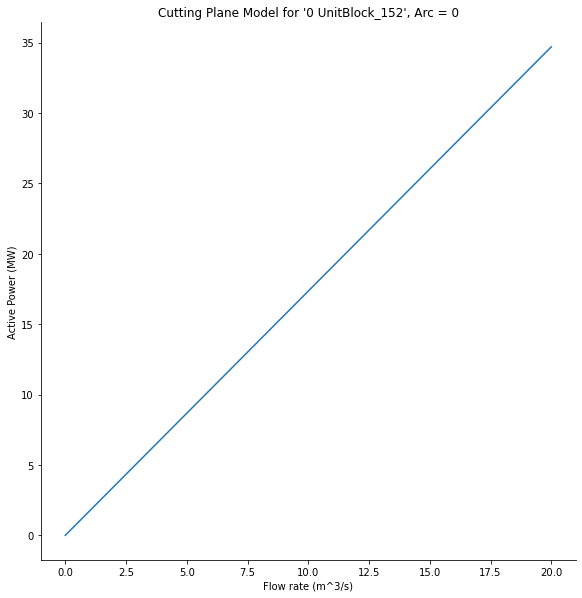

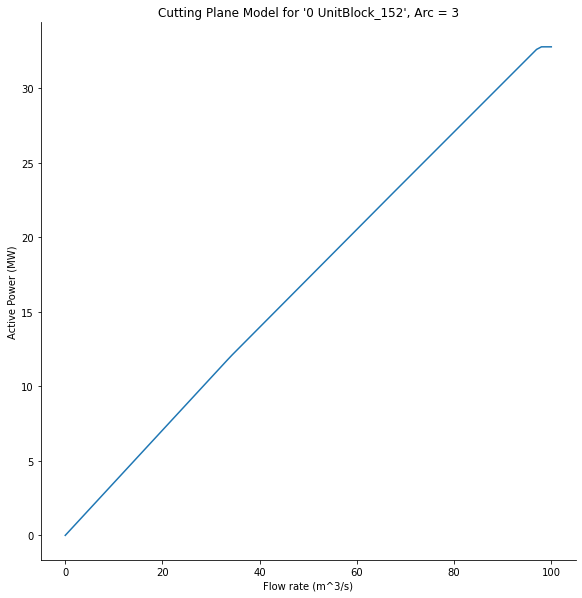

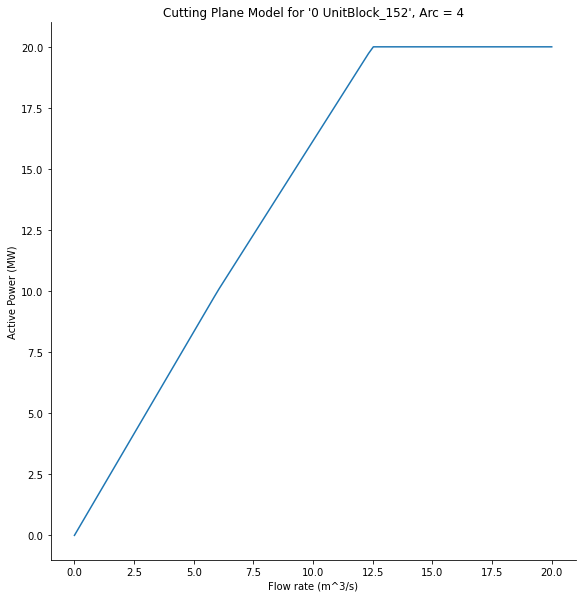

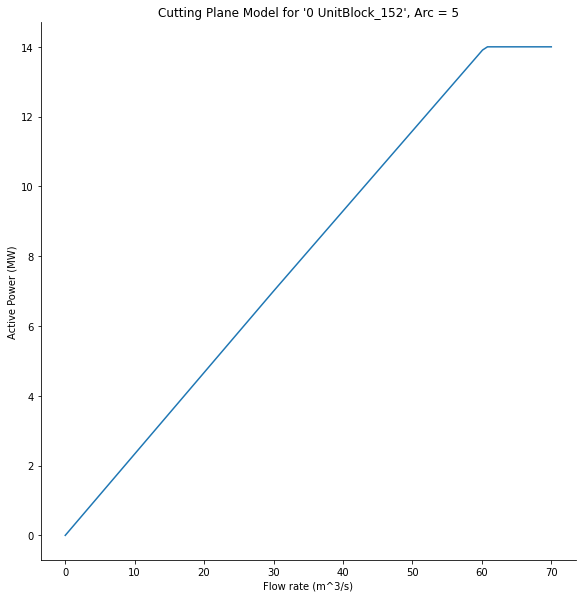

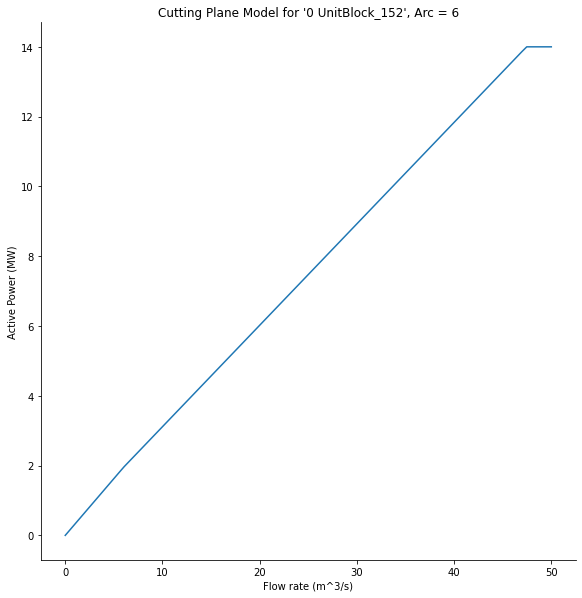

In [32]:
# First we will use the 'matplotlib inline' magic command to decide how the graphs are displayed.
%matplotlib inline

hydro_number = 3                                                                                                        # Select which hydro block will be used from without_duplicates. This number is the row number in that dataframe. 
a = np.array(remove_nan(list(select_columns(without_duplicates, ["NumberPieces"]).iloc[hydro_number])))                 # Get all the values for the "NumberPieces" variable.
b = np.array(remove_nan(list(select_columns(without_duplicates, ["LinearTerm"]).iloc[hydro_number])))                   # Get all the values for the "LinearTerm" variable.
c = np.array(remove_nan(list(select_columns(without_duplicates, ["ConstantTerm"]).iloc[hydro_number])))                 # Get all the values for the "ConstantTerm" variable.

datalist = []                                                                                                           # Create an empty list for data.
all_x = []                                                                                                              # Create an empty list for x values.
count = 0                                                                                                               # Create a count variable to keep track of the number of pieces already dealt with.
for j in a:                                                                                                             # Loop over the list of "NumberPieces" values...
    max_x = 1e-4                                                                                                          # In order to create the x values below, a limit (maximum x value) needs to be given. Initially we give a very small maximum x value and we gradually increase it in a while loop below, so that it is large enough for each graph.
    xvals = np.linspace(0,max_x,100)                                                                                      # Create 100 x points between 0 and the maximum x point ('max_x').
    
    # Now we will use a while loop to make sure that the maximum x for each graph is large enough for the graph
    # to level off (if it does). We make sure this maximum is not more than 1000 to make sure the while loop
    # terminates eventually.
    
    while c[count+j-1]> min([3600*xvals[-1]*b[count+i]+c[count+i] for i in range(j)]) and max_x < 1000:                  # While the final constant term for the current arc is larger than the power for the final x value, and while 'max_x'<1000, do...
        max_x+=10                                                                                                         # Increase the maximum x by 10. This might seem too large, but it is chosen so that the levelling off is seen more easily.
        xvals = np.linspace(0,max_x,100)                                                                                  # Update the x values so that they go from 0 to the new maximum.
    datalist.append(np.array([min([3600*x*b[count+i]+c[count+i] for i in range(j)]) for x in xvals]))                    # Add the power values for the current arc into the 'datalist' list.
    all_x.append(xvals)                                                                                                  # Add the x values for the current arc to the list 'all_x'.
    count+=j                                                                                                             # Add j to the count. This is because the loop will go to the next arc and needs to know where the linear/ constant terms start for that arc.

# Below we create the graphs.
    
count = 0                                                                                                               # Create a count variable to keep track of the arc number being used in the for loop below.
for d in datalist:                                                                                                      # Loop over the list of power value lists.
    xvals = all_x[count]                                                                                                 # Get the x values for the current arc from 'all_x'.
    if a[count]>1:                                                                                                       # If there is more than 1 piece (i.e. if the graph is interesting enough to plot), then...
        graph = sns.relplot(x = xvals,y=d, kind = "line", height = 8, aspect = 1)                                         # Create the graph using seaborn's relplot.
        Title = "Cutting Plane Model for "                                                                                # Start creating the title for the graph.
        Title += "'{}'".format(without_duplicates.index[hydro_number])                                                    # Add the block name to the title.
        Title += ", Arc = {}".format(count)                                                                               # Add the arc number to the title.
        graph.set(xlabel = "Flow rate (m^3/s)", ylabel = "Active Power (MW)", title = Title)                              # Set the axis titles.
    count+=1                                                                                                             # Increase count by one since the for loop will move to the next arc now.

In order to analyse the graphs it might be useful to have a list of the Number of Pieces for each arc and all the linear and constant terms for the block.

In [33]:
a = np.array(remove_nan(list(select_columns(without_duplicates, ["NumberPieces"]).iloc[hydro_number])))
b = np.array(remove_nan(list(select_columns(without_duplicates, ["LinearTerm"]).iloc[hydro_number])))
c = np.array(remove_nan(list(select_columns(without_duplicates, ["ConstantTerm"]).iloc[hydro_number])))

print("NumberPieces: {}".format(a))
print("LinearTerms: \n {}".format(b))
print("ConstantTerms: \n {}".format(c))

NumberPieces: [ 4  1  2  4  3  3  3 13]
LinearTerms: 
 [4.8203e-04 4.7504e-04 4.7504e-04 4.1152e-04 0.0000e+00 1.1966e-04
 0.0000e+00 9.8039e-05 9.1211e-05 9.0655e-05 0.0000e+00 4.6296e-04
 4.2735e-04 0.0000e+00 6.4815e-05 6.3752e-05 0.0000e+00 9.0334e-05
 8.0745e-05 0.0000e+00 5.5556e-05 5.5556e-05 5.5556e-05 5.5556e-05
 5.5556e-05 5.5556e-05 5.5556e-05 5.5556e-05 5.5556e-05 5.5556e-05
 5.5556e-05 5.5556e-05 0.0000e+00]
ConstantTerms: 
 [ 0.        0.855072  0.855072 24.4074    0.        0.       14.
  0.        0.835821  0.970822 32.7907    0.        0.769231 20.
  0.        0.114754 14.        0.        0.207126 14.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.       48.      ]
